In [1]:
from ArticlesRep import MeanSimilarityoneindustry,MeanSimilaritytwoindustry #common function

import pandas as pd

import numpy as np

%matplotlib inline

import pickle

import visdom

from tqdm import tnrange, tqdm_notebook
from tqdm.autonotebook import tqdm
tqdm.pandas()

from time import time,sleep
from datetime import datetime

from sklearn.metrics.pairwise import cosine_similarity
# import visdom
# vis=visdom.Visdom()
# env="TagBased"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# %matplotlib inline

import re
import sys
import os
from pprint import pprint
#coding:utf-8

#solved chinese display in matplotlib
from pylab import mpl
mpl.rcParams["font.family"] = 'DFKai-sb' 
mpl.rcParams['axes.unicode_minus'] = False

list_industry=["水泥","食品飲料","石化","紡織","電機機械","電器電纜","化學工業",
               "建材居家用品","造紙","鋼鐵金屬","車輛相關","科技相關","營建地產","運輸","觀光休閒娛樂",
               "金融相關","百貨通路","公用事業","控股","生技醫療保健","農林漁牧","航天軍工","能源","傳播出版","綜合",
               "傳產其他","其他","金屬礦採選",
              ]
element="氫氦鋰鈹硼碳氮氧氟氖鈉鎂鋁矽磷硫氯氬鉀鈣鈧鈦釩鉻錳鐵鈷鎳銅鋅鎵鍺砷硒溴氪銣鍶銀鎘銦錫銻碲碘氙銫鋇鉑金汞鉈鉛鉍釙氡鍅鐳"

C:\Users\garyyu\AppData\Local\Continuum\anaconda3\envs\deeplearningcpu\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from keras.layers import Dense,Lambda,Input,Dot,Add,Subtract,GaussianDropout
from keras.utils import Sequence,plot_model
from keras.models import Model,load_model
from keras import backend as K


Using TensorFlow backend.


### Denoising Autoencoder with weak supervision

In [3]:
# custommed function
def noisefunction(x):
    x_noise=K.ones_like(x)
    return K.in_train_phase(x_noise,x,1)

def tripletlossfunction(inputs):
    r01=inputs[0]
    r02=inputs[1]
    loss=K.log(1+K.exp(r02-r01))
#     x=np.array([[0],[1],[0],[1]])
#     x=K.variable(x)
    return loss

def losspassfunction(y_true,y_pred):
    return y_pred

def test(inputs):
#     x=K.dot(inputs,k.transpose(inputs))
    x=K.transpose(inputs)
    return x

In [4]:
x=Input(shape=(5,))
y=Lambda(noisefunction)(x)
model=Model(x,y)
x=np.arange(2*5).reshape((2,5))
model.predict(x)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [5]:
K.clear_session()
np.random.seed(100)
###############
# instantiate layer
# noise=Lambda(noisefunction,name="noisefunction")
# trilosslayer=Lambda(Triplet,name="trilosslayer")
# dense=Dense(units=12000,activation="sigmoid",name="Dense1")
###############
#model path
path="Models/Model3_on_all_industry"
if not os.path.isdir(path):
    os.mkdir(path)

#parameter setting    
BOW_dim=19404
DR_dim=100
loss_weights=[1,1,1,2]

##Encoder
x=Input((BOW_dim,),name="encoder_input")
y=GaussianDropout(rate=0.2,name="noise")(x)
# y=Dense(units=2000,activation="sigmoid",name="Dense_1")(y)
y=Dense(units=DR_dim,activation="sigmoid",name="Dense_1",use_bias=False)(y)
encoder=Model(x,y,name="encoder")

##Decoder
x=Input((DR_dim,),name="input") 
y=x
y=Dense(units=BOW_dim,activation="sigmoid",use_bias=True,name="Dense_1")(y)
# y=Dense(units=BOW_dim,activation="sigmoid",name="Dense_2")(y)
decoder=Model(x,y,name="decoder")

##Tripletloss
x0=Input((DR_dim,),name="anchor_input")
x1=Input((DR_dim,),name="positive_input")
x2=Input((DR_dim,),name="negative_input")
r01=Dot(axes=1,name="SimiPositive")([x0,x1])
r02=Dot(axes=1,name="SimiNegative")([x0,x2])
out=Lambda(tripletlossfunction,name="tripletlossfunction")([r01,r02])
tripletloss=Model(inputs=[x0,x1,x2],outputs=out,name="triplet")

#Build Tri-Autoencoder model
x0=Input((BOW_dim,),name="anchor_input")
x1=Input((BOW_dim,),name="positive_input")
x2=Input((BOW_dim,),name="negative_input")

h0=encoder(x0)
h1=encoder(x1)
h2=encoder(x2)

Lt=tripletloss([h0,h1,h2])

y0=decoder(h0)
y1=decoder(h1)
y2=decoder(h2)

y0=Lambda(lambda x :x ,name="anchor")(y0)
y1=Lambda(lambda x :x ,name="positive")(y1)
y2=Lambda(lambda x :x ,name="negative")(y2)

# triplet_loss

Tri_AutoEncoder=Model(inputs=[x0,x1,x2],outputs=[y0,y1,y2,Lt])
Tri_AutoEncoder.compile(optimizer="adam",
                        loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy',losspassfunction],
                        loss_weights=loss_weights
                       )
#save initial model
Tri_AutoEncoder.save("{}/Tri_AutoEncoder.initial.h5".format(path))
# encoder.save("encoder.initial.h5")
# decoder.save("decoder.initial.h5")
#plot
plot_model(Tri_AutoEncoder,to_file="{}/Tri_DenoiseAutoEncoder.png".format(path))
plot_model(encoder,to_file="{}/encoder.png".format(path))
plot_model(decoder,to_file="{}/decoder.png".format(path))
# Open the file to record
with open('{}/Tri_AutoEencoderncoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    Tri_AutoEncoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('{}/encoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    encoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))
with open('{}/decoder.summary.txt'.format(path),'w') as f:
    # Pass the file handle in as a lambda function to make it callable
    decoder.summary(print_fn=lambda x: f.write("    "+x + '\n'))

Tri_AutoEncoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 19404)        0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 19404)        0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 19404)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 100)          1940400     anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

## Load Data

In [6]:
Data=np.load("D:3.AutoencoderForArticle/BOW_binary_v02.npy")

In [7]:
with open("D:3.AutoencoderForArticle/train_dict_collect_industry_50000.p","rb") as f:
    train_dict_collect_industry_50000=pickle.load(f)

In [8]:
train_dict_collect_industry_50000.pop("控股","沒有")

array([  2249,  39220, 124022])

In [9]:
with open("D:3.AutoencoderForArticle/test_dict_collect_industry_50000.p","rb") as f:
    test_dict_collect_industry_50000=pickle.load(f)

In [10]:
test_dict_collect_industry_50000.pop("控股","沒有")

array([76531])

## Data generator

In [11]:
class DataGenerator(Sequence):

    def __init__(self, tripletindex,Data, batch_size=32):
        self.tripletindex= np.asarray(tripletindex)
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        self.batch_size = batch_size
        self.Data=Data

    def __len__(self):
         return int(np.ceil(self.tripletindex.shape[0] / float(self.batch_size)))
#         return 1
    def __getitem__(self, idx):
        batch_index = self.tripletindex[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_anchor = self.Data[batch_index[:,0]]
        batch_positive = self.Data[batch_index[:,1]]
        batch_negative = self.Data[batch_index[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        pick=np.random.permutation(len(self.tripletindex))
        self.tripletindex= self.tripletindex[pick]
        

In [12]:
class HardTriGenerator(Sequence):

    def __init__(self, dict_id_news,Data, P=3,K=3):
        self.dict_id_news=dict_id_news
        self.industry=np.asarray(list(dict_id_news.keys()))
#         pick=np.random.permutation(len(self.tripletindex))
#         self.tripletindex= self.tripletindex[pick]
        self.P=P
        self.K=K
        self.Data=Data

    def __len__(self):
        return int(np.floor(len(self.industry) / self.P))
#         return 1
    def __getitem__(self, idx):
        indusrty= self.industry[idx*self.P:(idx+1)*self.P]
        small_dict_id_news={i:np.random.choice(self.dict_id_news[i],size=self.K,replace=False) for i in indusrty}
        dict_small_triplet=dict()
        for k in small_dict_id_news:
            poslist=small_dict_id_news[k]
            poslen=len(poslist)
            neglist=[]
            for j in small_dict_id_news:
                if k!=j:neglist+=list(small_dict_id_news[j])
                neglen=len(neglist)
            indarray=np.zeros((int(poslen*(poslen-1)*neglen),3),dtype=int)
            i=0
            for ip1_,a in enumerate(poslist):
                for ip2_,p in enumerate(poslist):
                    if ip1_!=ip2_:
                        for in_,n in enumerate(neglist):
        #                   print(p1,p2,n)
                            indarray[i,0]=a
                            indarray[i,1]=p
                            indarray[i,2]=n
                            i+=1
        #                 break
        #             break
        #         break
            dict_small_triplet[k]=indarray            
        for i,k in enumerate(dict_small_triplet):
            if i==0:tripletindex=dict_small_triplet[k]
            else:tripletindex=np.concatenate((tripletindex,dict_small_triplet[k]),axis=0)   
        batch_anchor=self.Data[tripletindex[:,0]]
        batch_positive=self.Data[tripletindex[:,1]]
        batch_negative=self.Data[tripletindex[:,2]]
        tripletloss=np.zeros((batch_negative.shape[0],1))    
        
        return [batch_anchor,batch_positive,batch_negative],[batch_anchor,batch_positive,batch_negative,tripletloss]
    def on_epoch_end(self):
        """Method called at the end of every epoch.
        """
        self.industry=np.random.permutation(self.industry)       

In [17]:
#setup

#instantiate generator
traingenerator=HardTriGenerator(dict_id_news=train_dict_collect_industry_50000,
                                Data=Data,
                                P=3, # remainder>=2;
                                K=5,
                               )
testgenerator=HardTriGenerator(dict_id_news=test_dict_collect_industry_50000,
                               Data=Data,P=3,K=5,
                              )

In [18]:
for _,i in enumerate(traingenerator):
    print(i[0][2].shape)
    break

(600, 19404)


## Callback function

In [19]:
from keras.callbacks import TerminateOnNaN,ModelCheckpoint,TensorBoard
#creat regular folder

regular_path =path+"/regular"
logname="model3allindustry50000"
if not os.path.isdir(regular_path):
    os.mkdir(regular_path)
# Instantiation claaback function
checkpointer = ModelCheckpoint(filepath='{}/bestmodel.hdf5'.format(path), verbose=0, save_best_only=True,period=10)
regularsave = ModelCheckpoint(filepath="{}".format(path)+'/regular/weights.{epoch:02d}.hdf5',
                              save_weights_only=True, 
                              verbose=0,
                              save_best_only=False,period=50)

tensorboard=TensorBoard(log_dir="./logs/{}".format(logname))

## Train

In [21]:
#initial
Tri_AutoEncoder=load_model("{}/Tri_AutoEncoder.initial.h5".format(path),custom_objects={"losspassfunction":losspassfunction})
#setup
epochs=4560
#train
History=Tri_AutoEncoder.fit_generator(callbacks=[checkpointer,tensorboard,regularsave],
                                      generator=traingenerator,
#                                       shuffle=True,
                                      epochs=epochs,
#                                       steps_per_epoch=steps_per_epoch,
                                      validation_data=testgenerator,
                                      verbose=2,
                                      workers=1,use_multiprocessing=False,
                                      
                                    
                                     )
#save model
Tri_AutoEncoder.save("{}/Tri_AutoEncoder_trained.h5".format(path))
Tri_AutoEncoder.save_weights("{}/weights.h5".format(path))

Epoch 1/4560
 - 15s - loss: 3.2495 - anchor_loss: 0.6147 - positive_loss: 0.6147 - negative_loss: 0.6148 - triplet_loss: 0.7026 - val_loss: 2.9808 - val_anchor_loss: 0.5192 - val_positive_loss: 0.5192 - val_negative_loss: 0.5192 - val_triplet_loss: 0.7116
Epoch 2/4560
 - 16s - loss: 2.8245 - anchor_loss: 0.4567 - positive_loss: 0.4567 - negative_loss: 0.4566 - triplet_loss: 0.7273 - val_loss: 2.6413 - val_anchor_loss: 0.3836 - val_positive_loss: 0.3836 - val_negative_loss: 0.3836 - val_triplet_loss: 0.7453
Epoch 3/4560
 - 15s - loss: 2.5952 - anchor_loss: 0.3383 - positive_loss: 0.3384 - negative_loss: 0.3382 - triplet_loss: 0.7902 - val_loss: 2.3823 - val_anchor_loss: 0.2869 - val_positive_loss: 0.2869 - val_negative_loss: 0.2869 - val_triplet_loss: 0.7608
Epoch 4/4560
 - 15s - loss: 2.3854 - anchor_loss: 0.2558 - positive_loss: 0.2557 - negative_loss: 0.2558 - triplet_loss: 0.8090 - val_loss: 2.1765 - val_anchor_loss: 0.2176 - val_positive_loss: 0.2176 - val_negative_loss: 0.2176 - v

Epoch 33/4560
 - 15s - loss: 1.5899 - anchor_loss: 0.0369 - positive_loss: 0.0368 - negative_loss: 0.0368 - triplet_loss: 0.7397 - val_loss: 1.4884 - val_anchor_loss: 0.0351 - val_positive_loss: 0.0351 - val_negative_loss: 0.0351 - val_triplet_loss: 0.6916
Epoch 34/4560
 - 15s - loss: 1.7224 - anchor_loss: 0.0366 - positive_loss: 0.0365 - negative_loss: 0.0366 - triplet_loss: 0.8064 - val_loss: 1.4878 - val_anchor_loss: 0.0367 - val_positive_loss: 0.0367 - val_negative_loss: 0.0367 - val_triplet_loss: 0.6889
Epoch 35/4560
 - 15s - loss: 1.5184 - anchor_loss: 0.0356 - positive_loss: 0.0355 - negative_loss: 0.0356 - triplet_loss: 0.7058 - val_loss: 1.5112 - val_anchor_loss: 0.0364 - val_positive_loss: 0.0364 - val_negative_loss: 0.0364 - val_triplet_loss: 0.7011
Epoch 36/4560
 - 15s - loss: 1.6885 - anchor_loss: 0.0353 - positive_loss: 0.0353 - negative_loss: 0.0353 - triplet_loss: 0.7913 - val_loss: 1.5761 - val_anchor_loss: 0.0344 - val_positive_loss: 0.0344 - val_negative_loss: 0.0344

Epoch 65/4560
 - 15s - loss: 1.3270 - anchor_loss: 0.0282 - positive_loss: 0.0282 - negative_loss: 0.0283 - triplet_loss: 0.6211 - val_loss: 1.4161 - val_anchor_loss: 0.0282 - val_positive_loss: 0.0282 - val_negative_loss: 0.0282 - val_triplet_loss: 0.6658
Epoch 66/4560
 - 15s - loss: 1.3200 - anchor_loss: 0.0285 - positive_loss: 0.0285 - negative_loss: 0.0285 - triplet_loss: 0.6172 - val_loss: 1.1252 - val_anchor_loss: 0.0277 - val_positive_loss: 0.0277 - val_negative_loss: 0.0277 - val_triplet_loss: 0.5210
Epoch 67/4560
 - 15s - loss: 1.3349 - anchor_loss: 0.0292 - positive_loss: 0.0292 - negative_loss: 0.0292 - triplet_loss: 0.6236 - val_loss: 1.1382 - val_anchor_loss: 0.0271 - val_positive_loss: 0.0271 - val_negative_loss: 0.0271 - val_triplet_loss: 0.5285
Epoch 68/4560
 - 14s - loss: 1.1098 - anchor_loss: 0.0278 - positive_loss: 0.0278 - negative_loss: 0.0278 - triplet_loss: 0.5132 - val_loss: 1.3330 - val_anchor_loss: 0.0283 - val_positive_loss: 0.0283 - val_negative_loss: 0.0283

Epoch 97/4560
 - 14s - loss: 1.0950 - anchor_loss: 0.0248 - positive_loss: 0.0248 - negative_loss: 0.0249 - triplet_loss: 0.5102 - val_loss: 0.9767 - val_anchor_loss: 0.0252 - val_positive_loss: 0.0252 - val_negative_loss: 0.0252 - val_triplet_loss: 0.4505
Epoch 98/4560
 - 15s - loss: 0.9507 - anchor_loss: 0.0248 - positive_loss: 0.0248 - negative_loss: 0.0248 - triplet_loss: 0.4382 - val_loss: 1.1632 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0233 - val_negative_loss: 0.0233 - val_triplet_loss: 0.5466
Epoch 99/4560
 - 15s - loss: 0.9446 - anchor_loss: 0.0254 - positive_loss: 0.0254 - negative_loss: 0.0254 - triplet_loss: 0.4342 - val_loss: 1.0331 - val_anchor_loss: 0.0253 - val_positive_loss: 0.0253 - val_negative_loss: 0.0253 - val_triplet_loss: 0.4786
Epoch 100/4560
 - 15s - loss: 1.0261 - anchor_loss: 0.0232 - positive_loss: 0.0232 - negative_loss: 0.0232 - triplet_loss: 0.4783 - val_loss: 1.0312 - val_anchor_loss: 0.0249 - val_positive_loss: 0.0249 - val_negative_loss: 0.024

Epoch 129/4560
 - 16s - loss: 0.7887 - anchor_loss: 0.0241 - positive_loss: 0.0241 - negative_loss: 0.0241 - triplet_loss: 0.3583 - val_loss: 0.8737 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0232 - val_negative_loss: 0.0232 - val_triplet_loss: 0.4020
Epoch 130/4560
 - 15s - loss: 0.8955 - anchor_loss: 0.0240 - positive_loss: 0.0240 - negative_loss: 0.0240 - triplet_loss: 0.4118 - val_loss: 0.7902 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0232 - val_negative_loss: 0.0232 - val_triplet_loss: 0.3603
Epoch 131/4560
 - 15s - loss: 0.7049 - anchor_loss: 0.0242 - positive_loss: 0.0242 - negative_loss: 0.0242 - triplet_loss: 0.3162 - val_loss: 0.9107 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0237 - val_negative_loss: 0.0237 - val_triplet_loss: 0.4198
Epoch 132/4560
 - 15s - loss: 0.7536 - anchor_loss: 0.0241 - positive_loss: 0.0241 - negative_loss: 0.0241 - triplet_loss: 0.3406 - val_loss: 0.8418 - val_anchor_loss: 0.0252 - val_positive_loss: 0.0252 - val_negative_loss: 0.

Epoch 161/4560
 - 15s - loss: 0.5409 - anchor_loss: 0.0239 - positive_loss: 0.0239 - negative_loss: 0.0239 - triplet_loss: 0.2345 - val_loss: 0.6776 - val_anchor_loss: 0.0238 - val_positive_loss: 0.0238 - val_negative_loss: 0.0238 - val_triplet_loss: 0.3031
Epoch 162/4560
 - 15s - loss: 0.6451 - anchor_loss: 0.0238 - positive_loss: 0.0238 - negative_loss: 0.0238 - triplet_loss: 0.2869 - val_loss: 0.9923 - val_anchor_loss: 0.0250 - val_positive_loss: 0.0250 - val_negative_loss: 0.0250 - val_triplet_loss: 0.4586
Epoch 163/4560
 - 14s - loss: 0.7243 - anchor_loss: 0.0236 - positive_loss: 0.0236 - negative_loss: 0.0236 - triplet_loss: 0.3268 - val_loss: 0.7902 - val_anchor_loss: 0.0247 - val_positive_loss: 0.0247 - val_negative_loss: 0.0247 - val_triplet_loss: 0.3580
Epoch 164/4560
 - 15s - loss: 0.5387 - anchor_loss: 0.0226 - positive_loss: 0.0227 - negative_loss: 0.0226 - triplet_loss: 0.2354 - val_loss: 0.7991 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0232 - val_negative_loss: 0.

Epoch 193/4560
 - 15s - loss: 0.6645 - anchor_loss: 0.0234 - positive_loss: 0.0234 - negative_loss: 0.0234 - triplet_loss: 0.2972 - val_loss: 0.7448 - val_anchor_loss: 0.0240 - val_positive_loss: 0.0240 - val_negative_loss: 0.0240 - val_triplet_loss: 0.3364
Epoch 194/4560
 - 15s - loss: 0.4945 - anchor_loss: 0.0230 - positive_loss: 0.0230 - negative_loss: 0.0230 - triplet_loss: 0.2128 - val_loss: 0.6879 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0234 - val_negative_loss: 0.0234 - val_triplet_loss: 0.3089
Epoch 195/4560
 - 15s - loss: 0.4727 - anchor_loss: 0.0235 - positive_loss: 0.0235 - negative_loss: 0.0235 - triplet_loss: 0.2011 - val_loss: 0.8463 - val_anchor_loss: 0.0244 - val_positive_loss: 0.0244 - val_negative_loss: 0.0244 - val_triplet_loss: 0.3866
Epoch 196/4560
 - 15s - loss: 0.6722 - anchor_loss: 0.0224 - positive_loss: 0.0224 - negative_loss: 0.0224 - triplet_loss: 0.3026 - val_loss: 0.9326 - val_anchor_loss: 0.0252 - val_positive_loss: 0.0252 - val_negative_loss: 0.

Epoch 225/4560
 - 15s - loss: 0.5594 - anchor_loss: 0.0227 - positive_loss: 0.0227 - negative_loss: 0.0227 - triplet_loss: 0.2456 - val_loss: 0.8111 - val_anchor_loss: 0.0235 - val_positive_loss: 0.0235 - val_negative_loss: 0.0235 - val_triplet_loss: 0.3703
Epoch 226/4560
 - 14s - loss: 0.4795 - anchor_loss: 0.0232 - positive_loss: 0.0232 - negative_loss: 0.0232 - triplet_loss: 0.2049 - val_loss: 0.8055 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.0223 - val_triplet_loss: 0.3693
Epoch 227/4560
 - 15s - loss: 0.5457 - anchor_loss: 0.0222 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 0.2395 - val_loss: 0.6737 - val_anchor_loss: 0.0249 - val_positive_loss: 0.0249 - val_negative_loss: 0.0249 - val_triplet_loss: 0.2995
Epoch 228/4560
 - 15s - loss: 0.4713 - anchor_loss: 0.0226 - positive_loss: 0.0226 - negative_loss: 0.0226 - triplet_loss: 0.2017 - val_loss: 0.9032 - val_anchor_loss: 0.0247 - val_positive_loss: 0.0247 - val_negative_loss: 0.

Epoch 257/4560
 - 15s - loss: 0.4847 - anchor_loss: 0.0244 - positive_loss: 0.0244 - negative_loss: 0.0244 - triplet_loss: 0.2058 - val_loss: 0.7782 - val_anchor_loss: 0.0234 - val_positive_loss: 0.0234 - val_negative_loss: 0.0234 - val_triplet_loss: 0.3540
Epoch 258/4560
 - 15s - loss: 0.3415 - anchor_loss: 0.0229 - positive_loss: 0.0229 - negative_loss: 0.0229 - triplet_loss: 0.1364 - val_loss: 0.6120 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0226 - val_negative_loss: 0.0226 - val_triplet_loss: 0.2721
Epoch 259/4560
 - 15s - loss: 0.3578 - anchor_loss: 0.0231 - positive_loss: 0.0231 - negative_loss: 0.0231 - triplet_loss: 0.1442 - val_loss: 0.7924 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.3618
Epoch 260/4560
 - 15s - loss: 0.3420 - anchor_loss: 0.0234 - positive_loss: 0.0234 - negative_loss: 0.0234 - triplet_loss: 0.1359 - val_loss: 0.7209 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0230 - val_negative_loss: 0.

Epoch 289/4560
 - 14s - loss: 0.2633 - anchor_loss: 0.0221 - positive_loss: 0.0221 - negative_loss: 0.0221 - triplet_loss: 0.0986 - val_loss: 0.8927 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0237 - val_negative_loss: 0.0237 - val_triplet_loss: 0.4107
Epoch 290/4560
 - 15s - loss: 0.3773 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.1576 - val_loss: 0.8693 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0231 - val_negative_loss: 0.0231 - val_triplet_loss: 0.3999
Epoch 291/4560
 - 14s - loss: 0.3158 - anchor_loss: 0.0224 - positive_loss: 0.0224 - negative_loss: 0.0224 - triplet_loss: 0.1243 - val_loss: 0.5762 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0227 - val_negative_loss: 0.0227 - val_triplet_loss: 0.2541
Epoch 292/4560
 - 15s - loss: 0.5563 - anchor_loss: 0.0222 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 0.2449 - val_loss: 0.7359 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0228 - val_negative_loss: 0.

Epoch 321/4560
 - 15s - loss: 0.3521 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 0.1440 - val_loss: 0.5674 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0231 - val_negative_loss: 0.0231 - val_triplet_loss: 0.2490
Epoch 322/4560
 - 15s - loss: 0.3770 - anchor_loss: 0.0225 - positive_loss: 0.0225 - negative_loss: 0.0225 - triplet_loss: 0.1548 - val_loss: 0.5539 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.2426
Epoch 323/4560
 - 15s - loss: 0.3748 - anchor_loss: 0.0226 - positive_loss: 0.0226 - negative_loss: 0.0226 - triplet_loss: 0.1534 - val_loss: 0.8418 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.3882
Epoch 324/4560
 - 15s - loss: 0.3057 - anchor_loss: 0.0226 - positive_loss: 0.0226 - negative_loss: 0.0226 - triplet_loss: 0.1189 - val_loss: 0.6246 - val_anchor_loss: 0.0233 - val_positive_loss: 0.0233 - val_negative_loss: 0.

Epoch 353/4560
 - 15s - loss: 0.2862 - anchor_loss: 0.0224 - positive_loss: 0.0224 - negative_loss: 0.0224 - triplet_loss: 0.1096 - val_loss: 0.4073 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0232 - val_negative_loss: 0.0232 - val_triplet_loss: 0.1688
Epoch 354/4560
 - 15s - loss: 0.4765 - anchor_loss: 0.0225 - positive_loss: 0.0225 - negative_loss: 0.0225 - triplet_loss: 0.2044 - val_loss: 0.6212 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0228 - val_negative_loss: 0.0228 - val_triplet_loss: 0.2764
Epoch 355/4560
 - 15s - loss: 0.2427 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0894 - val_loss: 0.5789 - val_anchor_loss: 0.0244 - val_positive_loss: 0.0244 - val_negative_loss: 0.0244 - val_triplet_loss: 0.2528
Epoch 356/4560
 - 15s - loss: 0.2494 - anchor_loss: 0.0220 - positive_loss: 0.0220 - negative_loss: 0.0220 - triplet_loss: 0.0917 - val_loss: 0.6352 - val_anchor_loss: 0.0237 - val_positive_loss: 0.0237 - val_negative_loss: 0.

Epoch 385/4560
 - 15s - loss: 0.1921 - anchor_loss: 0.0239 - positive_loss: 0.0239 - negative_loss: 0.0239 - triplet_loss: 0.0602 - val_loss: 0.5991 - val_anchor_loss: 0.0236 - val_positive_loss: 0.0236 - val_negative_loss: 0.0236 - val_triplet_loss: 0.2642
Epoch 386/4560
 - 15s - loss: 0.2229 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0798 - val_loss: 0.5177 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0231 - val_negative_loss: 0.0231 - val_triplet_loss: 0.2243
Epoch 387/4560
 - 15s - loss: 0.3363 - anchor_loss: 0.0226 - positive_loss: 0.0226 - negative_loss: 0.0226 - triplet_loss: 0.1343 - val_loss: 0.5487 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.2429
Epoch 388/4560
 - 15s - loss: 0.2725 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.1041 - val_loss: 0.5023 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.

Epoch 417/4560
 - 15s - loss: 0.2500 - anchor_loss: 0.0225 - positive_loss: 0.0225 - negative_loss: 0.0225 - triplet_loss: 0.0913 - val_loss: 0.7191 - val_anchor_loss: 0.0242 - val_positive_loss: 0.0242 - val_negative_loss: 0.0242 - val_triplet_loss: 0.3232
Epoch 418/4560
 - 15s - loss: 0.2265 - anchor_loss: 0.0218 - positive_loss: 0.0218 - negative_loss: 0.0218 - triplet_loss: 0.0806 - val_loss: 0.5810 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.0224 - val_triplet_loss: 0.2568
Epoch 419/4560
 - 15s - loss: 0.1764 - anchor_loss: 0.0226 - positive_loss: 0.0226 - negative_loss: 0.0226 - triplet_loss: 0.0544 - val_loss: 0.5858 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.0224 - val_triplet_loss: 0.2593
Epoch 420/4560
 - 15s - loss: 0.2758 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.1067 - val_loss: 0.8436 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0228 - val_negative_loss: 0.

Epoch 449/4560
 - 15s - loss: 0.2423 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0905 - val_loss: 0.4668 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.0223 - val_triplet_loss: 0.2000
Epoch 450/4560
 - 15s - loss: 0.2321 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0850 - val_loss: 0.4952 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.2167
Epoch 451/4560
 - 15s - loss: 0.3700 - anchor_loss: 0.0227 - positive_loss: 0.0227 - negative_loss: 0.0227 - triplet_loss: 0.1510 - val_loss: 0.4562 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0227 - val_negative_loss: 0.0227 - val_triplet_loss: 0.1941
Epoch 452/4560
 - 15s - loss: 0.1876 - anchor_loss: 0.0223 - positive_loss: 0.0223 - negative_loss: 0.0223 - triplet_loss: 0.0603 - val_loss: 0.6419 - val_anchor_loss: 0.0228 - val_positive_loss: 0.0228 - val_negative_loss: 0.

Epoch 481/4560
 - 15s - loss: 0.2610 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 0.1001 - val_loss: 0.5432 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0230 - val_negative_loss: 0.0230 - val_triplet_loss: 0.2371
Epoch 482/4560
 - 15s - loss: 0.2042 - anchor_loss: 0.0227 - positive_loss: 0.0227 - negative_loss: 0.0227 - triplet_loss: 0.0680 - val_loss: 0.7738 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.0224 - val_triplet_loss: 0.3533
Epoch 483/4560
 - 15s - loss: 0.2771 - anchor_loss: 0.0217 - positive_loss: 0.0217 - negative_loss: 0.0217 - triplet_loss: 0.1060 - val_loss: 0.6443 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.2899
Epoch 484/4560
 - 15s - loss: 0.2925 - anchor_loss: 0.0220 - positive_loss: 0.0220 - negative_loss: 0.0220 - triplet_loss: 0.1133 - val_loss: 0.4559 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.

Epoch 513/4560
 - 15s - loss: 0.2358 - anchor_loss: 0.0222 - positive_loss: 0.0222 - negative_loss: 0.0222 - triplet_loss: 0.0846 - val_loss: 0.5923 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.2653
Epoch 514/4560
 - 15s - loss: 0.2219 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0790 - val_loss: 0.6218 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2790
Epoch 515/4560
 - 15s - loss: 0.2296 - anchor_loss: 0.0223 - positive_loss: 0.0223 - negative_loss: 0.0223 - triplet_loss: 0.0814 - val_loss: 0.5922 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2637
Epoch 516/4560
 - 14s - loss: 0.2539 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0950 - val_loss: 0.6121 - val_anchor_loss: 0.0230 - val_positive_loss: 0.0230 - val_negative_loss: 0.

Epoch 545/4560
 - 15s - loss: 0.1801 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.0577 - val_loss: 0.6057 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.2685
Epoch 546/4560
 - 15s - loss: 0.2387 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0877 - val_loss: 0.4988 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.2178
Epoch 547/4560
 - 15s - loss: 0.1796 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0579 - val_loss: 0.4326 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.1820
Epoch 548/4560
 - 15s - loss: 0.1661 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0511 - val_loss: 0.4310 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.

Epoch 577/4560
 - 15s - loss: 0.1301 - anchor_loss: 0.0215 - positive_loss: 0.0215 - negative_loss: 0.0215 - triplet_loss: 0.0328 - val_loss: 0.5686 - val_anchor_loss: 0.0232 - val_positive_loss: 0.0232 - val_negative_loss: 0.0232 - val_triplet_loss: 0.2495
Epoch 578/4560
 - 15s - loss: 0.2351 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0870 - val_loss: 0.8505 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.3921
Epoch 579/4560
 - 15s - loss: 0.1970 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0673 - val_loss: 0.4723 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.2045
Epoch 580/4560
 - 15s - loss: 0.2191 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0789 - val_loss: 0.5406 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss: 0.

Epoch 609/4560
 - 15s - loss: 0.2479 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0941 - val_loss: 0.3622 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1490
Epoch 610/4560
 - 16s - loss: 0.1503 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0434 - val_loss: 0.4921 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.2145
Epoch 611/4560
 - 16s - loss: 0.1954 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0660 - val_loss: 0.3901 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0227 - val_negative_loss: 0.0227 - val_triplet_loss: 0.1609
Epoch 612/4560
 - 16s - loss: 0.1905 - anchor_loss: 0.0213 - positive_loss: 0.0213 - negative_loss: 0.0213 - triplet_loss: 0.0632 - val_loss: 0.4658 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.

Epoch 641/4560
 - 15s - loss: 0.2388 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0876 - val_loss: 0.4319 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0226 - val_negative_loss: 0.0226 - val_triplet_loss: 0.1821
Epoch 642/4560
 - 15s - loss: 0.1975 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0688 - val_loss: 0.6090 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2723
Epoch 643/4560
 - 15s - loss: 0.1772 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0580 - val_loss: 0.4581 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1968
Epoch 644/4560
 - 16s - loss: 0.2568 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.0959 - val_loss: 0.5414 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.

Epoch 673/4560
 - 15s - loss: 0.2097 - anchor_loss: 0.0209 - positive_loss: 0.0209 - negative_loss: 0.0209 - triplet_loss: 0.0735 - val_loss: 0.4227 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0226 - val_negative_loss: 0.0226 - val_triplet_loss: 0.1774
Epoch 674/4560
 - 15s - loss: 0.2182 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 0.0771 - val_loss: 0.4480 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.0224 - val_triplet_loss: 0.1903
Epoch 675/4560
 - 15s - loss: 0.1653 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0524 - val_loss: 0.6478 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.0224 - val_triplet_loss: 0.2903
Epoch 676/4560
 - 15s - loss: 0.1892 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0635 - val_loss: 0.4372 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.

Epoch 705/4560
 - 15s - loss: 0.1163 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 0.0260 - val_loss: 0.3219 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1295
Epoch 706/4560
 - 15s - loss: 0.1555 - anchor_loss: 0.0219 - positive_loss: 0.0219 - negative_loss: 0.0219 - triplet_loss: 0.0449 - val_loss: 0.4026 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1696
Epoch 707/4560
 - 16s - loss: 0.0970 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0178 - val_loss: 0.4839 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2096
Epoch 708/4560
 - 15s - loss: 0.1709 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0561 - val_loss: 0.4419 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.

Epoch 737/4560
 - 15s - loss: 0.1191 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0288 - val_loss: 0.5998 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2679
Epoch 738/4560
 - 15s - loss: 0.1767 - anchor_loss: 0.0210 - positive_loss: 0.0210 - negative_loss: 0.0210 - triplet_loss: 0.0569 - val_loss: 0.5374 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.2371
Epoch 739/4560
 - 15s - loss: 0.0962 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0172 - val_loss: 0.3207 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.1284
Epoch 740/4560
 - 15s - loss: 0.1926 - anchor_loss: 0.0210 - positive_loss: 0.0210 - negative_loss: 0.0210 - triplet_loss: 0.0648 - val_loss: 0.5707 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.

Epoch 769/4560
 - 15s - loss: 0.0996 - anchor_loss: 0.0204 - positive_loss: 0.0204 - negative_loss: 0.0204 - triplet_loss: 0.0193 - val_loss: 0.6223 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.2796
Epoch 770/4560
 - 15s - loss: 0.1596 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0480 - val_loss: 0.6441 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.2891
Epoch 771/4560
 - 15s - loss: 0.1194 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.0272 - val_loss: 0.3657 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.1505
Epoch 772/4560
 - 15s - loss: 0.1158 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0282 - val_loss: 0.3836 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.

Epoch 801/4560
 - 15s - loss: 0.1560 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0485 - val_loss: 0.5163 - val_anchor_loss: 0.0227 - val_positive_loss: 0.0227 - val_negative_loss: 0.0227 - val_triplet_loss: 0.2241
Epoch 802/4560
 - 14s - loss: 0.1415 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0396 - val_loss: 0.4379 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.1864
Epoch 803/4560
 - 15s - loss: 0.1596 - anchor_loss: 0.0197 - positive_loss: 0.0198 - negative_loss: 0.0197 - triplet_loss: 0.0502 - val_loss: 0.5982 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.0224 - val_triplet_loss: 0.2656
Epoch 804/4560
 - 15s - loss: 0.1343 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0359 - val_loss: 0.4637 - val_anchor_loss: 0.0224 - val_positive_loss: 0.0224 - val_negative_loss: 0.

Epoch 833/4560
 - 15s - loss: 0.0854 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0120 - val_loss: 0.5123 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2236
Epoch 834/4560
 - 15s - loss: 0.1365 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0380 - val_loss: 0.3759 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1559
Epoch 835/4560
 - 15s - loss: 0.1192 - anchor_loss: 0.0211 - positive_loss: 0.0211 - negative_loss: 0.0211 - triplet_loss: 0.0279 - val_loss: 0.3482 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.1415
Epoch 836/4560
 - 15s - loss: 0.1725 - anchor_loss: 0.0216 - positive_loss: 0.0216 - negative_loss: 0.0216 - triplet_loss: 0.0539 - val_loss: 0.3192 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.

Epoch 865/4560
 - 15s - loss: 0.0978 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0176 - val_loss: 0.4402 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.0223 - val_triplet_loss: 0.1866
Epoch 866/4560
 - 15s - loss: 0.0934 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0160 - val_loss: 0.3696 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1532
Epoch 867/4560
 - 15s - loss: 0.1010 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0218 - val_loss: 0.5364 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2381
Epoch 868/4560
 - 15s - loss: 0.1400 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 0.0395 - val_loss: 0.4652 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.

Epoch 897/4560
 - 15s - loss: 0.1515 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0463 - val_loss: 0.4813 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2087
Epoch 898/4560
 - 15s - loss: 0.1543 - anchor_loss: 0.0203 - positive_loss: 0.0202 - negative_loss: 0.0203 - triplet_loss: 0.0468 - val_loss: 0.5816 - val_anchor_loss: 0.0231 - val_positive_loss: 0.0231 - val_negative_loss: 0.0231 - val_triplet_loss: 0.2561
Epoch 899/4560
 - 15s - loss: 0.1024 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0199 - val_loss: 0.3913 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1635
Epoch 900/4560
 - 15s - loss: 0.1418 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0409 - val_loss: 0.4490 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.

Epoch 929/4560
 - 15s - loss: 0.1404 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0395 - val_loss: 0.4820 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2089
Epoch 930/4560
 - 15s - loss: 0.1064 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0220 - val_loss: 0.3994 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0226 - val_negative_loss: 0.0226 - val_triplet_loss: 0.1658
Epoch 931/4560
 - 15s - loss: 0.1259 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 0.0325 - val_loss: 0.4951 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.2153
Epoch 932/4560
 - 15s - loss: 0.1052 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0229 - val_loss: 0.3072 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.

Epoch 961/4560
 - 15s - loss: 0.0890 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0135 - val_loss: 0.4640 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2000
Epoch 962/4560
 - 15s - loss: 0.1090 - anchor_loss: 0.0193 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 0.0255 - val_loss: 0.6684 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.3023
Epoch 963/4560
 - 15s - loss: 0.1039 - anchor_loss: 0.0214 - positive_loss: 0.0214 - negative_loss: 0.0214 - triplet_loss: 0.0198 - val_loss: 0.3669 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1512
Epoch 964/4560
 - 14s - loss: 0.1486 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0456 - val_loss: 0.4300 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.

Epoch 993/4560
 - 14s - loss: 0.1492 - anchor_loss: 0.0196 - positive_loss: 0.0196 - negative_loss: 0.0196 - triplet_loss: 0.0452 - val_loss: 0.7114 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.3234
Epoch 994/4560
 - 15s - loss: 0.1221 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0315 - val_loss: 0.3453 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1416
Epoch 995/4560
 - 15s - loss: 0.1184 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0293 - val_loss: 0.4459 - val_anchor_loss: 0.0226 - val_positive_loss: 0.0226 - val_negative_loss: 0.0226 - val_triplet_loss: 0.1891
Epoch 996/4560
 - 15s - loss: 0.1370 - anchor_loss: 0.0218 - positive_loss: 0.0218 - negative_loss: 0.0218 - triplet_loss: 0.0358 - val_loss: 0.3647 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.

Epoch 1025/4560
 - 15s - loss: 0.0903 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0164 - val_loss: 0.4968 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.2158
Epoch 1026/4560
 - 15s - loss: 0.1334 - anchor_loss: 0.0203 - positive_loss: 0.0203 - negative_loss: 0.0203 - triplet_loss: 0.0363 - val_loss: 0.4666 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.2003
Epoch 1027/4560
 - 15s - loss: 0.1484 - anchor_loss: 0.0212 - positive_loss: 0.0212 - negative_loss: 0.0212 - triplet_loss: 0.0425 - val_loss: 0.4117 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1735
Epoch 1028/4560
 - 15s - loss: 0.0738 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0071 - val_loss: 0.3545 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss

Epoch 1057/4560
 - 15s - loss: 0.1065 - anchor_loss: 0.0207 - positive_loss: 0.0207 - negative_loss: 0.0207 - triplet_loss: 0.0222 - val_loss: 0.3399 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1390
Epoch 1058/4560
 - 15s - loss: 0.0844 - anchor_loss: 0.0208 - positive_loss: 0.0208 - negative_loss: 0.0208 - triplet_loss: 0.0110 - val_loss: 0.5992 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2670
Epoch 1059/4560
 - 15s - loss: 0.1144 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0264 - val_loss: 0.4667 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.2015
Epoch 1060/4560
 - 15s - loss: 0.1163 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0294 - val_loss: 0.5288 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss

Epoch 1089/4560
 - 15s - loss: 0.1133 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0279 - val_loss: 0.4335 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss: 0.0219 - val_triplet_loss: 0.1838
Epoch 1090/4560
 - 15s - loss: 0.1169 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0289 - val_loss: 0.4122 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.1736
Epoch 1091/4560
 - 15s - loss: 0.0795 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0088 - val_loss: 0.5589 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.2468
Epoch 1092/4560
 - 14s - loss: 0.1022 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0225 - val_loss: 0.4340 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss

Epoch 1121/4560
 - 15s - loss: 0.0728 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0067 - val_loss: 0.5770 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.2553
Epoch 1122/4560
 - 15s - loss: 0.0875 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0137 - val_loss: 0.4415 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1886
Epoch 1123/4560
 - 15s - loss: 0.0813 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0099 - val_loss: 0.5089 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.2230
Epoch 1124/4560
 - 15s - loss: 0.0802 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0094 - val_loss: 0.5954 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss

Epoch 1153/4560
 - 15s - loss: 0.1326 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0355 - val_loss: 0.4368 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1866
Epoch 1154/4560
 - 15s - loss: 0.0745 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0066 - val_loss: 0.5367 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.2362
Epoch 1155/4560
 - 15s - loss: 0.0887 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0148 - val_loss: 0.4808 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.2091
Epoch 1156/4560
 - 15s - loss: 0.0814 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0120 - val_loss: 0.3864 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss

Epoch 1185/4560
 - 15s - loss: 0.0752 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0078 - val_loss: 0.3510 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1444
Epoch 1186/4560
 - 14s - loss: 0.1253 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0334 - val_loss: 0.5000 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.2185
Epoch 1187/4560
 - 15s - loss: 0.1046 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0226 - val_loss: 0.6139 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.2760
Epoch 1188/4560
 - 14s - loss: 0.0720 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0086 - val_loss: 0.4184 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss

Epoch 1217/4560
 - 14s - loss: 0.1116 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0260 - val_loss: 0.3816 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1604
Epoch 1218/4560
 - 15s - loss: 0.0727 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0056 - val_loss: 0.3426 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.1386
Epoch 1219/4560
 - 14s - loss: 0.1015 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0221 - val_loss: 0.5810 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2580
Epoch 1220/4560
 - 15s - loss: 0.0776 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0100 - val_loss: 0.5326 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss

Epoch 1249/4560
 - 15s - loss: 0.0806 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0203 - triplet_loss: 0.0099 - val_loss: 0.4489 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.1939
Epoch 1250/4560
 - 14s - loss: 0.0652 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0044 - val_loss: 0.4329 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1855
Epoch 1251/4560
 - 15s - loss: 0.0734 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0081 - val_loss: 0.5278 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.2308
Epoch 1252/4560
 - 14s - loss: 0.0763 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0084 - val_loss: 0.4412 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss

Epoch 1281/4560
 - 14s - loss: 0.0738 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0069 - val_loss: 0.4869 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2110
Epoch 1282/4560
 - 15s - loss: 0.0713 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0056 - val_loss: 0.3619 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1502
Epoch 1283/4560
 - 15s - loss: 0.0834 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0138 - val_loss: 0.6183 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2789
Epoch 1284/4560
 - 15s - loss: 0.0916 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0155 - val_loss: 0.5281 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss

Epoch 1313/4560
 - 15s - loss: 0.0804 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0110 - val_loss: 0.2202 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.0796
Epoch 1314/4560
 - 14s - loss: 0.1198 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0299 - val_loss: 0.2594 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.0990
Epoch 1315/4560
 - 15s - loss: 0.0705 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0061 - val_loss: 0.3702 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1534
Epoch 1316/4560
 - 14s - loss: 0.0802 - anchor_loss: 0.0193 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 0.0111 - val_loss: 0.3945 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss

Epoch 1345/4560
 - 14s - loss: 0.1086 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0247 - val_loss: 0.4634 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.2024
Epoch 1346/4560
 - 15s - loss: 0.0681 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0048 - val_loss: 0.3422 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss: 0.0221 - val_triplet_loss: 0.1380
Epoch 1347/4560
 - 14s - loss: 0.1200 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0309 - val_loss: 0.3801 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1596
Epoch 1348/4560
 - 14s - loss: 0.0831 - anchor_loss: 0.0202 - positive_loss: 0.0202 - negative_loss: 0.0202 - triplet_loss: 0.0113 - val_loss: 0.3897 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss

Epoch 1377/4560
 - 14s - loss: 0.0843 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0126 - val_loss: 0.4561 - val_anchor_loss: 0.0223 - val_positive_loss: 0.0223 - val_negative_loss: 0.0223 - val_triplet_loss: 0.1946
Epoch 1378/4560
 - 14s - loss: 0.0735 - anchor_loss: 0.0206 - positive_loss: 0.0206 - negative_loss: 0.0206 - triplet_loss: 0.0059 - val_loss: 0.3095 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1230
Epoch 1379/4560
 - 15s - loss: 0.0682 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0051 - val_loss: 0.4756 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2057
Epoch 1380/4560
 - 14s - loss: 0.0754 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 0.0100 - val_loss: 0.5325 - val_anchor_loss: 0.0221 - val_positive_loss: 0.0221 - val_negative_loss

Epoch 1409/4560
 - 14s - loss: 0.0729 - anchor_loss: 0.0208 - positive_loss: 0.0207 - negative_loss: 0.0208 - triplet_loss: 0.0053 - val_loss: 0.3737 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1550
Epoch 1410/4560
 - 15s - loss: 0.0829 - anchor_loss: 0.0193 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 0.0125 - val_loss: 0.3685 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1536
Epoch 1411/4560
 - 14s - loss: 0.0796 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0117 - val_loss: 0.4725 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2055
Epoch 1412/4560
 - 15s - loss: 0.0911 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0149 - val_loss: 0.3491 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss

Epoch 1441/4560
 - 15s - loss: 0.0967 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0192 - val_loss: 0.3475 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1430
Epoch 1442/4560
 - 14s - loss: 0.0980 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0193 - val_loss: 0.5113 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2248
Epoch 1443/4560
 - 14s - loss: 0.0729 - anchor_loss: 0.0200 - positive_loss: 0.0200 - negative_loss: 0.0200 - triplet_loss: 0.0064 - val_loss: 0.5412 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2386
Epoch 1444/4560
 - 15s - loss: 0.0906 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0152 - val_loss: 0.3951 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss

Epoch 1473/4560
 - 15s - loss: 0.0825 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0128 - val_loss: 0.4600 - val_anchor_loss: 0.0229 - val_positive_loss: 0.0229 - val_negative_loss: 0.0229 - val_triplet_loss: 0.1956
Epoch 1474/4560
 - 14s - loss: 0.0759 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0078 - val_loss: 0.3409 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1397
Epoch 1475/4560
 - 15s - loss: 0.0780 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0104 - val_loss: 0.4581 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1970
Epoch 1476/4560
 - 14s - loss: 0.0786 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0102 - val_loss: 0.2954 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss

Epoch 1505/4560
 - 14s - loss: 0.0904 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0151 - val_loss: 0.5332 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2345
Epoch 1506/4560
 - 15s - loss: 0.0734 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0076 - val_loss: 0.4688 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2023
Epoch 1507/4560
 - 14s - loss: 0.0819 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0130 - val_loss: 0.2471 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.0935
Epoch 1508/4560
 - 15s - loss: 0.0951 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0183 - val_loss: 0.4122 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss

Epoch 1537/4560
 - 15s - loss: 0.0691 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0070 - val_loss: 0.3982 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1690
Epoch 1538/4560
 - 14s - loss: 0.1442 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0437 - val_loss: 0.4060 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss: 0.0222 - val_triplet_loss: 0.1697
Epoch 1539/4560
 - 15s - loss: 0.0895 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0176 - val_loss: 0.4729 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2039
Epoch 1540/4560
 - 14s - loss: 0.0716 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0060 - val_loss: 0.2755 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss

Epoch 1569/4560
 - 14s - loss: 0.0843 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0139 - val_loss: 0.5466 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2409
Epoch 1570/4560
 - 15s - loss: 0.0831 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0129 - val_loss: 0.5381 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.2378
Epoch 1571/4560
 - 14s - loss: 0.0707 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0185 - triplet_loss: 0.0075 - val_loss: 0.4760 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.2066
Epoch 1572/4560
 - 15s - loss: 0.0622 - anchor_loss: 0.0191 - positive_loss: 0.0190 - negative_loss: 0.0191 - triplet_loss: 0.0025 - val_loss: 0.6271 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss

Epoch 1601/4560
 - 15s - loss: 0.0790 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 0.0117 - val_loss: 0.6818 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.3089
Epoch 1602/4560
 - 14s - loss: 0.0776 - anchor_loss: 0.0197 - positive_loss: 0.0197 - negative_loss: 0.0197 - triplet_loss: 0.0092 - val_loss: 0.5789 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2591
Epoch 1603/4560
 - 15s - loss: 0.0742 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0104 - val_loss: 0.4207 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1795
Epoch 1604/4560
 - 14s - loss: 0.1143 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0286 - val_loss: 0.4922 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss

Epoch 1633/4560
 - 14s - loss: 0.0927 - anchor_loss: 0.0193 - positive_loss: 0.0193 - negative_loss: 0.0193 - triplet_loss: 0.0174 - val_loss: 0.4962 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.2156
Epoch 1634/4560
 - 15s - loss: 0.0635 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0030 - val_loss: 0.5000 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2176
Epoch 1635/4560
 - 14s - loss: 0.0672 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0052 - val_loss: 0.3551 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.1493
Epoch 1636/4560
 - 15s - loss: 0.0686 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0056 - val_loss: 0.3852 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss

Epoch 1665/4560
 - 15s - loss: 0.0809 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0120 - val_loss: 0.6642 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.3008
Epoch 1666/4560
 - 14s - loss: 0.0716 - anchor_loss: 0.0205 - positive_loss: 0.0205 - negative_loss: 0.0205 - triplet_loss: 0.0050 - val_loss: 0.2775 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1090
Epoch 1667/4560
 - 15s - loss: 0.0773 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0121 - val_loss: 0.3085 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1229
Epoch 1668/4560
 - 14s - loss: 0.0619 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 0.0034 - val_loss: 0.5520 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss

Epoch 1697/4560
 - 14s - loss: 0.0833 - anchor_loss: 0.0198 - positive_loss: 0.0198 - negative_loss: 0.0198 - triplet_loss: 0.0120 - val_loss: 0.3084 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1233
Epoch 1698/4560
 - 15s - loss: 0.0654 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0036 - val_loss: 0.3485 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1425
Epoch 1699/4560
 - 14s - loss: 0.0994 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0215 - val_loss: 0.4869 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2132
Epoch 1700/4560
 - 15s - loss: 0.0879 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0166 - val_loss: 0.5069 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss

Epoch 1729/4560
 - 15s - loss: 0.0676 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0065 - val_loss: 0.3212 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1284
Epoch 1730/4560
 - 14s - loss: 0.0630 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 0.0037 - val_loss: 0.4761 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.2065
Epoch 1731/4560
 - 15s - loss: 0.0663 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0041 - val_loss: 0.4960 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.2191
Epoch 1732/4560
 - 14s - loss: 0.0808 - anchor_loss: 0.0192 - positive_loss: 0.0192 - negative_loss: 0.0192 - triplet_loss: 0.0116 - val_loss: 0.5348 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss

Epoch 1761/4560
 - 14s - loss: 0.0679 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0053 - val_loss: 0.4505 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1957
Epoch 1762/4560
 - 15s - loss: 0.0599 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0019 - val_loss: 0.4475 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1940
Epoch 1763/4560
 - 14s - loss: 0.0805 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0119 - val_loss: 0.5706 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.2523
Epoch 1764/4560
 - 15s - loss: 0.0690 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0063 - val_loss: 0.3705 - val_anchor_loss: 0.0222 - val_positive_loss: 0.0222 - val_negative_loss

Epoch 1793/4560
 - 15s - loss: 0.0801 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0102 - val_loss: 0.4737 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.2063
Epoch 1794/4560
 - 14s - loss: 0.0647 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0064 - val_loss: 0.6913 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.3144
Epoch 1795/4560
 - 15s - loss: 0.1103 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0279 - val_loss: 0.3931 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1654
Epoch 1796/4560
 - 14s - loss: 0.0657 - anchor_loss: 0.0199 - positive_loss: 0.0199 - negative_loss: 0.0199 - triplet_loss: 0.0030 - val_loss: 0.5715 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss

Epoch 1825/4560
 - 14s - loss: 0.1125 - anchor_loss: 0.0201 - positive_loss: 0.0201 - negative_loss: 0.0201 - triplet_loss: 0.0261 - val_loss: 0.6791 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.3076
Epoch 1826/4560
 - 15s - loss: 0.0796 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0127 - val_loss: 0.3974 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.1665
Epoch 1827/4560
 - 14s - loss: 0.0702 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0069 - val_loss: 0.4219 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1805
Epoch 1828/4560
 - 14s - loss: 0.0806 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0120 - val_loss: 0.3875 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss

Epoch 1857/4560
 - 15s - loss: 0.0979 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0198 - val_loss: 0.7050 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.3211
Epoch 1858/4560
 - 14s - loss: 0.0644 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0052 - val_loss: 0.6923 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.3157
Epoch 1859/4560
 - 14s - loss: 0.0733 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0083 - val_loss: 0.5084 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2234
Epoch 1860/4560
 - 15s - loss: 0.0564 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0024 - val_loss: 0.3113 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss

Epoch 1889/4560
 - 15s - loss: 0.0789 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0127 - val_loss: 0.3898 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1628
Epoch 1890/4560
 - 14s - loss: 0.0680 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 0.0062 - val_loss: 0.4830 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.2104
Epoch 1891/4560
 - 15s - loss: 0.0679 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0052 - val_loss: 0.4807 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2083
Epoch 1892/4560
 - 14s - loss: 0.0643 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0047 - val_loss: 0.4599 - val_anchor_loss: 0.0225 - val_positive_loss: 0.0225 - val_negative_loss

Epoch 1921/4560
 - 15s - loss: 0.0642 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0041 - val_loss: 0.3411 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.1407
Epoch 1922/4560
 - 15s - loss: 0.0675 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0064 - val_loss: 0.3786 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1586
Epoch 1923/4560
 - 14s - loss: 0.0677 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0071 - val_loss: 0.3722 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.1538
Epoch 1924/4560
 - 15s - loss: 0.0689 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0073 - val_loss: 0.4835 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss

Epoch 1953/4560
 - 15s - loss: 0.0662 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0052 - val_loss: 0.4563 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1980
Epoch 1954/4560
 - 14s - loss: 0.0679 - anchor_loss: 0.0191 - positive_loss: 0.0191 - negative_loss: 0.0191 - triplet_loss: 0.0053 - val_loss: 0.4237 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1802
Epoch 1955/4560
 - 15s - loss: 0.0868 - anchor_loss: 0.0194 - positive_loss: 0.0194 - negative_loss: 0.0194 - triplet_loss: 0.0142 - val_loss: 0.5183 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.2286
Epoch 1956/4560
 - 14s - loss: 0.0599 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0024 - val_loss: 0.3773 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss

Epoch 1985/4560
 - 14s - loss: 0.1300 - anchor_loss: 0.0195 - positive_loss: 0.0195 - negative_loss: 0.0195 - triplet_loss: 0.0358 - val_loss: 0.5780 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2570
Epoch 1986/4560
 - 15s - loss: 0.0683 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0070 - val_loss: 0.2714 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1049
Epoch 1987/4560
 - 14s - loss: 0.0636 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0057 - val_loss: 0.5248 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2322
Epoch 1988/4560
 - 15s - loss: 0.0630 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0034 - val_loss: 0.7315 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss

Epoch 2017/4560
 - 15s - loss: 0.0665 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0064 - val_loss: 0.7216 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.3295
Epoch 2018/4560
 - 14s - loss: 0.0966 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0222 - val_loss: 0.5770 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.2575
Epoch 2019/4560
 - 15s - loss: 0.1047 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0250 - val_loss: 0.8192 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.3801
Epoch 2020/4560
 - 14s - loss: 0.0939 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0198 - val_loss: 0.3956 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss

Epoch 2049/4560
 - 14s - loss: 0.0765 - anchor_loss: 0.0182 - positive_loss: 0.0182 - negative_loss: 0.0182 - triplet_loss: 0.0109 - val_loss: 0.2541 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0969
Epoch 2050/4560
 - 15s - loss: 0.0626 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0034 - val_loss: 0.5027 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.2200
Epoch 2051/4560
 - 14s - loss: 0.0629 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0051 - val_loss: 0.3729 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0186 - val_negative_loss: 0.0186 - val_triplet_loss: 0.1585
Epoch 2052/4560
 - 15s - loss: 0.0713 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0082 - val_loss: 0.3404 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss

Epoch 2081/4560
 - 15s - loss: 0.0712 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0081 - val_loss: 0.8154 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.3770
Epoch 2082/4560
 - 14s - loss: 0.0549 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0017 - val_loss: 0.3572 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.1485
Epoch 2083/4560
 - 15s - loss: 0.0645 - anchor_loss: 0.0183 - positive_loss: 0.0184 - negative_loss: 0.0183 - triplet_loss: 0.0048 - val_loss: 0.4542 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1956
Epoch 2084/4560
 - 14s - loss: 0.0757 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0110 - val_loss: 0.3911 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss

Epoch 2113/4560
 - 14s - loss: 0.0710 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0081 - val_loss: 0.3969 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1689
Epoch 2114/4560
 - 15s - loss: 0.0681 - anchor_loss: 0.0190 - positive_loss: 0.0190 - negative_loss: 0.0190 - triplet_loss: 0.0055 - val_loss: 0.3656 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1510
Epoch 2115/4560
 - 14s - loss: 0.0646 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0177 - triplet_loss: 0.0057 - val_loss: 0.8792 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.4082
Epoch 2116/4560
 - 15s - loss: 0.0676 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0085 - val_loss: 0.5873 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss

Epoch 2145/4560
 - 15s - loss: 0.0768 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0119 - val_loss: 0.5580 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.2470
Epoch 2146/4560
 - 14s - loss: 0.0656 - anchor_loss: 0.0176 - positive_loss: 0.0175 - negative_loss: 0.0176 - triplet_loss: 0.0065 - val_loss: 0.4439 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.1898
Epoch 2147/4560
 - 15s - loss: 0.0628 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0047 - val_loss: 0.4909 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.2145
Epoch 2148/4560
 - 14s - loss: 0.0734 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0103 - val_loss: 0.6242 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss

Epoch 2177/4560
 - 14s - loss: 0.0604 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0027 - val_loss: 0.4489 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss: 0.0219 - val_triplet_loss: 0.1916
Epoch 2178/4560
 - 15s - loss: 0.0716 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0091 - val_loss: 0.4673 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2033
Epoch 2179/4560
 - 14s - loss: 0.0644 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0056 - val_loss: 0.4174 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.1768
Epoch 2180/4560
 - 14s - loss: 0.0594 - anchor_loss: 0.0189 - positive_loss: 0.0189 - negative_loss: 0.0189 - triplet_loss: 0.0013 - val_loss: 0.5632 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss

Epoch 2209/4560
 - 14s - loss: 0.0562 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0025 - val_loss: 0.4832 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2114
Epoch 2210/4560
 - 15s - loss: 0.0599 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0032 - val_loss: 0.5369 - val_anchor_loss: 0.0215 - val_positive_loss: 0.0215 - val_negative_loss: 0.0215 - val_triplet_loss: 0.2362
Epoch 2211/4560
 - 14s - loss: 0.0681 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0074 - val_loss: 0.4139 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1767
Epoch 2212/4560
 - 15s - loss: 0.0564 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0029 - val_loss: 0.6706 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss

Epoch 2241/4560
 - 15s - loss: 0.0571 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0017 - val_loss: 0.3563 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1484
Epoch 2242/4560
 - 14s - loss: 0.0673 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 0.0060 - val_loss: 0.5387 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.2400
Epoch 2243/4560
 - 15s - loss: 0.0908 - anchor_loss: 0.0183 - positive_loss: 0.0183 - negative_loss: 0.0183 - triplet_loss: 0.0180 - val_loss: 0.5105 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2252
Epoch 2244/4560
 - 14s - loss: 0.0661 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0059 - val_loss: 0.3082 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss

Epoch 2273/4560
 - 14s - loss: 0.0591 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0033 - val_loss: 0.6222 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2790
Epoch 2274/4560
 - 15s - loss: 0.0617 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0049 - val_loss: 0.5222 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.2319
Epoch 2275/4560
 - 14s - loss: 0.0617 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0028 - val_loss: 0.4353 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.1877
Epoch 2276/4560
 - 15s - loss: 0.0733 - anchor_loss: 0.0186 - positive_loss: 0.0186 - negative_loss: 0.0186 - triplet_loss: 0.0087 - val_loss: 0.4232 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss

Epoch 2305/4560
 - 15s - loss: 0.0561 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0022 - val_loss: 0.4963 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2180
Epoch 2306/4560
 - 14s - loss: 0.0559 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0022 - val_loss: 0.3922 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.1671
Epoch 2307/4560
 - 15s - loss: 0.0576 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0026 - val_loss: 0.4841 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2121
Epoch 2308/4560
 - 14s - loss: 0.0613 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0052 - val_loss: 0.4206 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0185 - val_negative_loss

Epoch 2337/4560
 - 14s - loss: 0.0993 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0231 - val_loss: 0.4794 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.2099
Epoch 2338/4560
 - 15s - loss: 0.0676 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0075 - val_loss: 0.4310 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1860
Epoch 2339/4560
 - 14s - loss: 0.0588 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0025 - val_loss: 0.5959 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.2664
Epoch 2340/4560
 - 15s - loss: 0.0575 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0023 - val_loss: 0.2419 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss

Epoch 2369/4560
 - 15s - loss: 0.0649 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0054 - val_loss: 0.5732 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.2550
Epoch 2370/4560
 - 14s - loss: 0.0546 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0022 - val_loss: 0.3737 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1561
Epoch 2371/4560
 - 15s - loss: 0.0837 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0155 - val_loss: 0.3690 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1550
Epoch 2372/4560
 - 14s - loss: 0.0600 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0034 - val_loss: 0.7327 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss

Epoch 2401/4560
 - 14s - loss: 0.0867 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0162 - val_loss: 0.5521 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.2446
Epoch 2402/4560
 - 15s - loss: 0.0581 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0033 - val_loss: 0.4580 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1982
Epoch 2403/4560
 - 14s - loss: 0.0593 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0044 - val_loss: 0.5194 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2295
Epoch 2404/4560
 - 15s - loss: 0.0634 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0059 - val_loss: 0.7551 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss

Epoch 2433/4560
 - 15s - loss: 0.0690 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0171 - triplet_loss: 0.0088 - val_loss: 0.5553 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.2490
Epoch 2434/4560
 - 14s - loss: 0.0689 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0063 - val_loss: 0.3226 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1306
Epoch 2435/4560
 - 15s - loss: 0.0640 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0053 - val_loss: 0.8852 - val_anchor_loss: 0.0217 - val_positive_loss: 0.0217 - val_negative_loss: 0.0217 - val_triplet_loss: 0.4100
Epoch 2436/4560
 - 14s - loss: 0.0513 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0014 - val_loss: 0.5721 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss

Epoch 2465/4560
 - 14s - loss: 0.0793 - anchor_loss: 0.0175 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0133 - val_loss: 0.7029 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.3219
Epoch 2466/4560
 - 15s - loss: 0.0663 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0081 - val_loss: 0.3971 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.1696
Epoch 2467/4560
 - 14s - loss: 0.0578 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0017 - val_loss: 0.4945 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.2162
Epoch 2468/4560
 - 14s - loss: 0.0638 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0068 - val_loss: 0.4721 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss

Epoch 2497/4560
 - 14s - loss: 0.0581 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0029 - val_loss: 0.3981 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1683
Epoch 2498/4560
 - 15s - loss: 0.0653 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0074 - val_loss: 0.3879 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1642
Epoch 2499/4560
 - 14s - loss: 0.0562 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0013 - val_loss: 0.3942 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1676
Epoch 2500/4560
 - 15s - loss: 0.0566 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0022 - val_loss: 0.5522 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss

Epoch 2529/4560
 - 15s - loss: 0.0529 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0015 - val_loss: 0.6191 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.2798
Epoch 2530/4560
 - 14s - loss: 0.0648 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0056 - val_loss: 0.4824 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.2120
Epoch 2531/4560
 - 15s - loss: 0.0620 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0050 - val_loss: 0.2940 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1166
Epoch 2532/4560
 - 14s - loss: 0.0623 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0030 - val_loss: 0.4682 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss

Epoch 2561/4560
 - 15s - loss: 0.0576 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0034 - val_loss: 0.5806 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.2598
Epoch 2562/4560
 - 15s - loss: 0.0626 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0043 - val_loss: 0.6193 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2795
Epoch 2563/4560
 - 14s - loss: 0.0567 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0025 - val_loss: 0.5738 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.2571
Epoch 2564/4560
 - 15s - loss: 0.0582 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0030 - val_loss: 0.5226 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss

Epoch 2593/4560
 - 15s - loss: 0.0589 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0027 - val_loss: 0.2578 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.0995
Epoch 2594/4560
 - 14s - loss: 0.0624 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0056 - val_loss: 0.5972 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2684
Epoch 2595/4560
 - 15s - loss: 0.0782 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0133 - val_loss: 0.2872 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.1147
Epoch 2596/4560
 - 14s - loss: 0.0571 - anchor_loss: 0.0180 - positive_loss: 0.0180 - negative_loss: 0.0180 - triplet_loss: 0.0015 - val_loss: 0.4736 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss

Epoch 2625/4560
 - 14s - loss: 0.0625 - anchor_loss: 0.0187 - positive_loss: 0.0187 - negative_loss: 0.0187 - triplet_loss: 0.0033 - val_loss: 0.6587 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.2967
Epoch 2626/4560
 - 15s - loss: 0.0647 - anchor_loss: 0.0188 - positive_loss: 0.0188 - negative_loss: 0.0188 - triplet_loss: 0.0042 - val_loss: 0.6133 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2760
Epoch 2627/4560
 - 14s - loss: 0.0675 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0074 - val_loss: 0.6101 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.2737
Epoch 2628/4560
 - 14s - loss: 0.0678 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0074 - val_loss: 0.4517 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss

Epoch 2657/4560
 - 15s - loss: 0.0544 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0019 - val_loss: 0.6077 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.2735
Epoch 2658/4560
 - 14s - loss: 0.0592 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0046 - val_loss: 0.2449 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.0930
Epoch 2659/4560
 - 15s - loss: 0.0584 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0028 - val_loss: 0.5145 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2266
Epoch 2660/4560
 - 14s - loss: 0.0630 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0170 - triplet_loss: 0.0059 - val_loss: 0.4428 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss

Epoch 2689/4560
 - 14s - loss: 0.0740 - anchor_loss: 0.0155 - positive_loss: 0.0154 - negative_loss: 0.0155 - triplet_loss: 0.0138 - val_loss: 0.3750 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.1583
Epoch 2690/4560
 - 15s - loss: 0.0537 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0017 - val_loss: 0.6210 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.2821
Epoch 2691/4560
 - 14s - loss: 0.0593 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0036 - val_loss: 0.2574 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0992
Epoch 2692/4560
 - 15s - loss: 0.0563 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0015 - val_loss: 0.6971 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss

Epoch 2721/4560
 - 15s - loss: 0.0558 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0027 - val_loss: 0.4620 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1999
Epoch 2722/4560
 - 14s - loss: 0.0558 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0013 - val_loss: 0.4403 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1885
Epoch 2723/4560
 - 15s - loss: 0.0617 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0057 - val_loss: 0.4848 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.2137
Epoch 2724/4560
 - 14s - loss: 0.0653 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0064 - val_loss: 0.4700 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss

Epoch 2753/4560
 - 14s - loss: 0.0877 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0175 - val_loss: 0.5510 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2453
Epoch 2754/4560
 - 15s - loss: 0.0660 - anchor_loss: 0.0179 - positive_loss: 0.0179 - negative_loss: 0.0179 - triplet_loss: 0.0061 - val_loss: 0.3594 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1487
Epoch 2755/4560
 - 14s - loss: 0.0736 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0110 - val_loss: 0.3672 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1534
Epoch 2756/4560
 - 14s - loss: 0.0566 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0016 - val_loss: 0.3537 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss

Epoch 2785/4560
 - 14s - loss: 0.0593 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0035 - val_loss: 0.2100 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.0752
Epoch 2786/4560
 - 15s - loss: 0.0523 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0018 - val_loss: 0.4062 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.1748
Epoch 2787/4560
 - 14s - loss: 0.0761 - anchor_loss: 0.0165 - positive_loss: 0.0165 - negative_loss: 0.0165 - triplet_loss: 0.0133 - val_loss: 0.2667 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.1049
Epoch 2788/4560
 - 15s - loss: 0.0559 - anchor_loss: 0.0157 - positive_loss: 0.0157 - negative_loss: 0.0157 - triplet_loss: 0.0043 - val_loss: 0.1403 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss

Epoch 2817/4560
 - 15s - loss: 0.0523 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 9.4446e-04 - val_loss: 0.6393 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2894
Epoch 2818/4560
 - 14s - loss: 0.0737 - anchor_loss: 0.0185 - positive_loss: 0.0185 - negative_loss: 0.0185 - triplet_loss: 0.0091 - val_loss: 0.5052 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.2214
Epoch 2819/4560
 - 15s - loss: 0.0519 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0019 - val_loss: 0.3382 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1388
Epoch 2820/4560
 - 14s - loss: 0.0572 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0021 - val_loss: 0.2808 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_

Epoch 2849/4560
 - 14s - loss: 0.0748 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0119 - val_loss: 0.6375 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2888
Epoch 2850/4560
 - 15s - loss: 0.0652 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0067 - val_loss: 0.4308 - val_anchor_loss: 0.0219 - val_positive_loss: 0.0219 - val_negative_loss: 0.0219 - val_triplet_loss: 0.1825
Epoch 2851/4560
 - 14s - loss: 0.0525 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 0.0016 - val_loss: 0.3806 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1598
Epoch 2852/4560
 - 15s - loss: 0.0578 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0040 - val_loss: 0.3337 - val_anchor_loss: 0.0178 - val_positive_loss: 0.0178 - val_negative_loss

Epoch 2881/4560
 - 14s - loss: 0.0577 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0029 - val_loss: 0.4081 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1738
Epoch 2882/4560
 - 14s - loss: 0.0577 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0039 - val_loss: 0.5945 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.2667
Epoch 2883/4560
 - 15s - loss: 0.0524 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0019 - val_loss: 0.3593 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1502
Epoch 2884/4560
 - 14s - loss: 0.0847 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0169 - val_loss: 0.3982 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss

Epoch 2913/4560
 - 14s - loss: 0.0734 - anchor_loss: 0.0177 - positive_loss: 0.0177 - negative_loss: 0.0177 - triplet_loss: 0.0102 - val_loss: 0.6947 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.3165
Epoch 2914/4560
 - 15s - loss: 0.0696 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0096 - val_loss: 0.4295 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.1856
Epoch 2915/4560
 - 14s - loss: 0.0519 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0010 - val_loss: 0.4378 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1876
Epoch 2916/4560
 - 15s - loss: 0.0512 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0164 - triplet_loss: 0.0011 - val_loss: 0.3806 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss

Epoch 2945/4560
 - 15s - loss: 0.0629 - anchor_loss: 0.0184 - positive_loss: 0.0184 - negative_loss: 0.0184 - triplet_loss: 0.0038 - val_loss: 0.4366 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1873
Epoch 2946/4560
 - 14s - loss: 0.0579 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0030 - val_loss: 0.6269 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.2849
Epoch 2947/4560
 - 15s - loss: 0.0564 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0019 - val_loss: 0.7921 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.3648
Epoch 2948/4560
 - 14s - loss: 0.0556 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0029 - val_loss: 0.5086 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss

Epoch 2977/4560
 - 14s - loss: 0.0549 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0036 - val_loss: 0.6617 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.3020
Epoch 2978/4560
 - 15s - loss: 0.0630 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0066 - val_loss: 0.4821 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2103
Epoch 2979/4560
 - 14s - loss: 0.0645 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0067 - val_loss: 0.8364 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.3884
Epoch 2980/4560
 - 15s - loss: 0.0803 - anchor_loss: 0.0165 - positive_loss: 0.0165 - negative_loss: 0.0165 - triplet_loss: 0.0154 - val_loss: 0.4251 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss

Epoch 3009/4560
 - 15s - loss: 0.0600 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0036 - val_loss: 0.7450 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.3435
Epoch 3010/4560
 - 14s - loss: 0.0501 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0012 - val_loss: 0.4805 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2100
Epoch 3011/4560
 - 15s - loss: 0.0563 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0022 - val_loss: 0.4040 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1704
Epoch 3012/4560
 - 14s - loss: 0.0509 - anchor_loss: 0.0165 - positive_loss: 0.0165 - negative_loss: 0.0165 - triplet_loss: 7.8392e-04 - val_loss: 0.4111 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_

Epoch 3041/4560
 - 15s - loss: 0.0626 - anchor_loss: 0.0181 - positive_loss: 0.0181 - negative_loss: 0.0181 - triplet_loss: 0.0042 - val_loss: 0.4785 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.2101
Epoch 3042/4560
 - 14s - loss: 0.0521 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0165 - triplet_loss: 0.0012 - val_loss: 0.2867 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.1117
Epoch 3043/4560
 - 15s - loss: 0.0513 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 7.2049e-04 - val_loss: 0.4988 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0188 - val_negative_loss: 0.0188 - val_triplet_loss: 0.2212
Epoch 3044/4560
 - 14s - loss: 0.0515 - anchor_loss: 0.0160 - positive_loss: 0.0159 - negative_loss: 0.0160 - triplet_loss: 0.0018 - val_loss: 0.5671 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_

Epoch 3073/4560
 - 14s - loss: 0.0558 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0025 - val_loss: 0.3172 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss: 0.0187 - val_triplet_loss: 0.1306
Epoch 3074/4560
 - 15s - loss: 0.0511 - anchor_loss: 0.0159 - positive_loss: 0.0160 - negative_loss: 0.0159 - triplet_loss: 0.0016 - val_loss: 0.8018 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.3700
Epoch 3075/4560
 - 14s - loss: 0.0727 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0100 - val_loss: 0.5622 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.2528
Epoch 3076/4560
 - 15s - loss: 0.0504 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0013 - val_loss: 0.4181 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss

Epoch 3105/4560
 - 15s - loss: 0.0566 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0029 - val_loss: 0.4333 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1869
Epoch 3106/4560
 - 14s - loss: 0.0566 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0030 - val_loss: 0.4600 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.2014
Epoch 3107/4560
 - 15s - loss: 0.0634 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0055 - val_loss: 0.5956 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.2684
Epoch 3108/4560
 - 14s - loss: 0.0541 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 6.6736e-04 - val_loss: 0.2155 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_

Epoch 3137/4560
 - 14s - loss: 0.0516 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0020 - val_loss: 0.4333 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.1878
Epoch 3138/4560
 - 15s - loss: 0.0614 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0054 - val_loss: 0.4662 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2031
Epoch 3139/4560
 - 14s - loss: 0.0542 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0015 - val_loss: 0.6747 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.3072
Epoch 3140/4560
 - 15s - loss: 0.0751 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 0.0131 - val_loss: 0.4139 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss

Epoch 3169/4560
 - 15s - loss: 0.0796 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0143 - val_loss: 0.5877 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.2647
Epoch 3170/4560
 - 14s - loss: 0.0604 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 0.0040 - val_loss: 0.4802 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.2115
Epoch 3171/4560
 - 15s - loss: 0.0707 - anchor_loss: 0.0157 - positive_loss: 0.0157 - negative_loss: 0.0157 - triplet_loss: 0.0118 - val_loss: 0.5017 - val_anchor_loss: 0.0218 - val_positive_loss: 0.0218 - val_negative_loss: 0.0218 - val_triplet_loss: 0.2181
Epoch 3172/4560
 - 14s - loss: 0.0572 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 0.0033 - val_loss: 0.5645 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss

Epoch 3201/4560
 - 14s - loss: 0.0641 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0067 - val_loss: 0.3430 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.1422
Epoch 3202/4560
 - 15s - loss: 0.0565 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0026 - val_loss: 0.5003 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.2200
Epoch 3203/4560
 - 14s - loss: 0.0522 - anchor_loss: 0.0168 - positive_loss: 0.0168 - negative_loss: 0.0168 - triplet_loss: 9.3468e-04 - val_loss: 0.3962 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.1671
Epoch 3204/4560
 - 15s - loss: 0.0532 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 0.0022 - val_loss: 0.5484 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_

Epoch 3233/4560
 - 14s - loss: 0.0539 - anchor_loss: 0.0173 - positive_loss: 0.0173 - negative_loss: 0.0173 - triplet_loss: 0.0011 - val_loss: 0.3578 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1494
Epoch 3234/4560
 - 14s - loss: 0.0558 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0042 - val_loss: 0.3803 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.1601
Epoch 3235/4560
 - 14s - loss: 0.0520 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0018 - val_loss: 0.4906 - val_anchor_loss: 0.0186 - val_positive_loss: 0.0186 - val_negative_loss: 0.0186 - val_triplet_loss: 0.2174
Epoch 3236/4560
 - 14s - loss: 0.0534 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0027 - val_loss: 0.4399 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss

Epoch 3265/4560
 - 14s - loss: 0.0507 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0015 - val_loss: 0.6690 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.3054
Epoch 3266/4560
 - 14s - loss: 0.0687 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0082 - val_loss: 0.3312 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1362
Epoch 3267/4560
 - 14s - loss: 0.0545 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0036 - val_loss: 0.4471 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0185 - val_negative_loss: 0.0185 - val_triplet_loss: 0.1957
Epoch 3268/4560
 - 14s - loss: 0.0530 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 0.0019 - val_loss: 0.5815 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss

Epoch 3297/4560
 - 14s - loss: 0.0895 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 0.0213 - val_loss: 0.4344 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.1873
Epoch 3298/4560
 - 15s - loss: 0.0531 - anchor_loss: 0.0153 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 0.0036 - val_loss: 0.2723 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.1069
Epoch 3299/4560
 - 14s - loss: 0.0658 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0092 - val_loss: 0.2928 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.1173
Epoch 3300/4560
 - 15s - loss: 0.0556 - anchor_loss: 0.0174 - positive_loss: 0.0174 - negative_loss: 0.0174 - triplet_loss: 0.0017 - val_loss: 0.5204 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss

Epoch 3329/4560
 - 15s - loss: 0.0539 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0014 - val_loss: 0.3398 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1404
Epoch 3330/4560
 - 14s - loss: 0.0684 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0105 - val_loss: 0.5392 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.2382
Epoch 3331/4560
 - 15s - loss: 0.0510 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0018 - val_loss: 0.4772 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.2099
Epoch 3332/4560
 - 14s - loss: 0.0556 - anchor_loss: 0.0165 - positive_loss: 0.0165 - negative_loss: 0.0165 - triplet_loss: 0.0031 - val_loss: 0.6296 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss

Epoch 3361/4560
 - 14s - loss: 0.0569 - anchor_loss: 0.0153 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 0.0054 - val_loss: 0.3936 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1665
Epoch 3362/4560
 - 15s - loss: 0.0531 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0017 - val_loss: 0.3362 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss: 0.0187 - val_triplet_loss: 0.1400
Epoch 3363/4560
 - 14s - loss: 0.0620 - anchor_loss: 0.0178 - positive_loss: 0.0178 - negative_loss: 0.0178 - triplet_loss: 0.0044 - val_loss: 0.3744 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1571
Epoch 3364/4560
 - 15s - loss: 0.0499 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 9.6497e-04 - val_loss: 0.2697 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_

Epoch 3393/4560
 - 15s - loss: 0.0501 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 7.4165e-04 - val_loss: 0.5555 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0188 - val_negative_loss: 0.0188 - val_triplet_loss: 0.2495
Epoch 3394/4560
 - 14s - loss: 0.0710 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 0.0121 - val_loss: 0.4790 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.2112
Epoch 3395/4560
 - 15s - loss: 0.0524 - anchor_loss: 0.0148 - positive_loss: 0.0148 - negative_loss: 0.0148 - triplet_loss: 0.0040 - val_loss: 0.5564 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.2487
Epoch 3396/4560
 - 14s - loss: 0.0600 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0064 - val_loss: 0.3420 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_

Epoch 3425/4560
 - 14s - loss: 0.0514 - anchor_loss: 0.0149 - positive_loss: 0.0149 - negative_loss: 0.0149 - triplet_loss: 0.0033 - val_loss: 0.6175 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.2800
Epoch 3426/4560
 - 15s - loss: 0.0705 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 0.0108 - val_loss: 0.6010 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.2709
Epoch 3427/4560
 - 14s - loss: 0.0521 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 0.0015 - val_loss: 0.2855 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1114
Epoch 3428/4560
 - 15s - loss: 0.0681 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0084 - val_loss: 0.4394 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss

Epoch 3457/4560
 - 15s - loss: 0.0479 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0155 - triplet_loss: 6.7754e-04 - val_loss: 0.5330 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.2371
Epoch 3458/4560
 - 14s - loss: 0.0537 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0019 - val_loss: 0.5607 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.2509
Epoch 3459/4560
 - 15s - loss: 0.0591 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0038 - val_loss: 0.4297 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.1835
Epoch 3460/4560
 - 14s - loss: 0.0775 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 0.0134 - val_loss: 0.6064 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_

Epoch 3489/4560
 - 14s - loss: 0.0513 - anchor_loss: 0.0165 - positive_loss: 0.0165 - negative_loss: 0.0165 - triplet_loss: 9.1765e-04 - val_loss: 0.4376 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0188 - val_negative_loss: 0.0188 - val_triplet_loss: 0.1905
Epoch 3490/4560
 - 15s - loss: 0.0505 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 7.8405e-04 - val_loss: 0.6861 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss: 0.0209 - val_triplet_loss: 0.3116
Epoch 3491/4560
 - 14s - loss: 0.0569 - anchor_loss: 0.0157 - positive_loss: 0.0157 - negative_loss: 0.0157 - triplet_loss: 0.0049 - val_loss: 0.3059 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1220
Epoch 3492/4560
 - 15s - loss: 0.0672 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0096 - val_loss: 0.4698 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negat

Epoch 3521/4560
 - 14s - loss: 0.0484 - anchor_loss: 0.0150 - positive_loss: 0.0150 - negative_loss: 0.0150 - triplet_loss: 0.0016 - val_loss: 0.4852 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.2133
Epoch 3522/4560
 - 14s - loss: 0.0592 - anchor_loss: 0.0157 - positive_loss: 0.0157 - negative_loss: 0.0157 - triplet_loss: 0.0061 - val_loss: 0.4555 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0188 - val_negative_loss: 0.0188 - val_triplet_loss: 0.1996
Epoch 3523/4560
 - 14s - loss: 0.0473 - anchor_loss: 0.0153 - positive_loss: 0.0154 - negative_loss: 0.0154 - triplet_loss: 6.4575e-04 - val_loss: 0.4056 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.1719
Epoch 3524/4560
 - 15s - loss: 0.0520 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0022 - val_loss: 0.3703 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_

Epoch 3553/4560
 - 15s - loss: 0.0527 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0015 - val_loss: 0.4718 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.2063
Epoch 3554/4560
 - 14s - loss: 0.0556 - anchor_loss: 0.0165 - positive_loss: 0.0165 - negative_loss: 0.0165 - triplet_loss: 0.0030 - val_loss: 0.1791 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.0600
Epoch 3555/4560
 - 15s - loss: 0.0566 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 0.0039 - val_loss: 0.4404 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1898
Epoch 3556/4560
 - 14s - loss: 0.0596 - anchor_loss: 0.0166 - positive_loss: 0.0167 - negative_loss: 0.0166 - triplet_loss: 0.0048 - val_loss: 0.3716 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss

Epoch 3585/4560
 - 14s - loss: 0.0502 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0010 - val_loss: 0.6065 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2732
Epoch 3586/4560
 - 15s - loss: 0.0515 - anchor_loss: 0.0154 - positive_loss: 0.0154 - negative_loss: 0.0154 - triplet_loss: 0.0027 - val_loss: 0.3897 - val_anchor_loss: 0.0188 - val_positive_loss: 0.0188 - val_negative_loss: 0.0188 - val_triplet_loss: 0.1667
Epoch 3587/4560
 - 14s - loss: 0.0557 - anchor_loss: 0.0176 - positive_loss: 0.0176 - negative_loss: 0.0176 - triplet_loss: 0.0014 - val_loss: 0.2670 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.1044
Epoch 3588/4560
 - 15s - loss: 0.0548 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0032 - val_loss: 0.5886 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss

Epoch 3617/4560
 - 15s - loss: 0.0508 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0015 - val_loss: 0.5226 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2311
Epoch 3618/4560
 - 14s - loss: 0.0479 - anchor_loss: 0.0151 - positive_loss: 0.0151 - negative_loss: 0.0151 - triplet_loss: 0.0013 - val_loss: 0.3513 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.1469
Epoch 3619/4560
 - 15s - loss: 0.0533 - anchor_loss: 0.0166 - positive_loss: 0.0166 - negative_loss: 0.0166 - triplet_loss: 0.0017 - val_loss: 0.4854 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.2140
Epoch 3620/4560
 - 14s - loss: 0.0555 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0034 - val_loss: 0.3697 - val_anchor_loss: 0.0209 - val_positive_loss: 0.0209 - val_negative_loss

Epoch 3649/4560
 - 14s - loss: 0.0724 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0155 - triplet_loss: 0.0130 - val_loss: 0.3131 - val_anchor_loss: 0.0204 - val_positive_loss: 0.0204 - val_negative_loss: 0.0204 - val_triplet_loss: 0.1260
Epoch 3650/4560
 - 15s - loss: 0.0536 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0017 - val_loss: 0.4088 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1749
Epoch 3651/4560
 - 14s - loss: 0.0534 - anchor_loss: 0.0154 - positive_loss: 0.0154 - negative_loss: 0.0155 - triplet_loss: 0.0035 - val_loss: 0.2950 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1180
Epoch 3652/4560
 - 15s - loss: 0.0471 - anchor_loss: 0.0150 - positive_loss: 0.0150 - negative_loss: 0.0150 - triplet_loss: 0.0010 - val_loss: 0.5777 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss

Epoch 3681/4560
 - 15s - loss: 0.0488 - anchor_loss: 0.0157 - positive_loss: 0.0157 - negative_loss: 0.0157 - triplet_loss: 7.9740e-04 - val_loss: 0.2934 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.1178
Epoch 3682/4560
 - 14s - loss: 0.0523 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 0.0016 - val_loss: 0.4102 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.1743
Epoch 3683/4560
 - 15s - loss: 0.0553 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0026 - val_loss: 0.4471 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.1936
Epoch 3684/4560
 - 14s - loss: 0.0503 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0012 - val_loss: 0.5966 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_

Epoch 3713/4560
 - 14s - loss: 0.0560 - anchor_loss: 0.0152 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 0.0051 - val_loss: 0.4518 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1958
Epoch 3714/4560
 - 15s - loss: 0.0492 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 0.0013 - val_loss: 0.2009 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.0719
Epoch 3715/4560
 - 14s - loss: 0.0543 - anchor_loss: 0.0175 - positive_loss: 0.0175 - negative_loss: 0.0175 - triplet_loss: 9.1618e-04 - val_loss: 0.6534 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.2973
Epoch 3716/4560
 - 14s - loss: 0.0497 - anchor_loss: 0.0154 - positive_loss: 0.0154 - negative_loss: 0.0153 - triplet_loss: 0.0018 - val_loss: 0.5593 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_

Epoch 3745/4560
 - 14s - loss: 0.0473 - anchor_loss: 0.0150 - positive_loss: 0.0150 - negative_loss: 0.0150 - triplet_loss: 0.0012 - val_loss: 0.4006 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.1717
Epoch 3746/4560
 - 14s - loss: 0.0505 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0154 - triplet_loss: 0.0021 - val_loss: 0.3421 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1417
Epoch 3747/4560
 - 14s - loss: 0.0573 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0043 - val_loss: 0.5249 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.2329
Epoch 3748/4560
 - 15s - loss: 0.0547 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0155 - triplet_loss: 0.0041 - val_loss: 0.6490 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss

Epoch 3777/4560
 - 15s - loss: 0.0543 - anchor_loss: 0.0157 - positive_loss: 0.0157 - negative_loss: 0.0157 - triplet_loss: 0.0036 - val_loss: 0.5500 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.2451
Epoch 3778/4560
 - 14s - loss: 0.0510 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0017 - val_loss: 0.5045 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.2228
Epoch 3779/4560
 - 15s - loss: 0.0542 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0035 - val_loss: 0.5151 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.2286
Epoch 3780/4560
 - 14s - loss: 0.0575 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0044 - val_loss: 0.3866 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss

Epoch 3809/4560
 - 14s - loss: 0.0457 - anchor_loss: 0.0148 - positive_loss: 0.0148 - negative_loss: 0.0148 - triplet_loss: 5.9545e-04 - val_loss: 0.3629 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.1524
Epoch 3810/4560
 - 15s - loss: 0.0543 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 0.0038 - val_loss: 0.3896 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1651
Epoch 3811/4560
 - 14s - loss: 0.0540 - anchor_loss: 0.0154 - positive_loss: 0.0154 - negative_loss: 0.0154 - triplet_loss: 0.0038 - val_loss: 0.4619 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2007
Epoch 3812/4560
 - 15s - loss: 0.0459 - anchor_loss: 0.0151 - positive_loss: 0.0151 - negative_loss: 0.0151 - triplet_loss: 3.8929e-04 - val_loss: 0.4018 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negat

Epoch 3841/4560
 - 15s - loss: 0.0468 - anchor_loss: 0.0151 - positive_loss: 0.0151 - negative_loss: 0.0151 - triplet_loss: 7.9054e-04 - val_loss: 0.3668 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.1544
Epoch 3842/4560
 - 14s - loss: 0.0504 - anchor_loss: 0.0150 - positive_loss: 0.0150 - negative_loss: 0.0150 - triplet_loss: 0.0028 - val_loss: 0.4842 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2121
Epoch 3843/4560
 - 15s - loss: 0.0555 - anchor_loss: 0.0170 - positive_loss: 0.0170 - negative_loss: 0.0170 - triplet_loss: 0.0022 - val_loss: 0.2857 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss: 0.0187 - val_triplet_loss: 0.1148
Epoch 3844/4560
 - 14s - loss: 0.0529 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0155 - triplet_loss: 0.0032 - val_loss: 0.3392 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_

Epoch 3873/4560
 - 14s - loss: 0.0489 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 3.3448e-04 - val_loss: 0.4457 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.1945
Epoch 3874/4560
 - 15s - loss: 0.0517 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0015 - val_loss: 0.5016 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.2218
Epoch 3875/4560
 - 14s - loss: 0.0480 - anchor_loss: 0.0157 - positive_loss: 0.0157 - negative_loss: 0.0157 - triplet_loss: 3.8549e-04 - val_loss: 0.5961 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.2693
Epoch 3876/4560
 - 15s - loss: 0.0588 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0057 - val_loss: 0.2153 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negat

Epoch 3905/4560
 - 15s - loss: 0.0470 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0155 - triplet_loss: 2.8891e-04 - val_loss: 0.7420 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0182 - val_negative_loss: 0.0182 - val_triplet_loss: 0.3437
Epoch 3906/4560
 - 14s - loss: 0.0502 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0011 - val_loss: 0.4243 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.1835
Epoch 3907/4560
 - 15s - loss: 0.0734 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0129 - val_loss: 0.3817 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.1610
Epoch 3908/4560
 - 14s - loss: 0.0516 - anchor_loss: 0.0169 - positive_loss: 0.0169 - negative_loss: 0.0169 - triplet_loss: 4.9896e-04 - val_loss: 0.4379 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negat

Epoch 3937/4560
 - 14s - loss: 0.0482 - anchor_loss: 0.0154 - positive_loss: 0.0154 - negative_loss: 0.0154 - triplet_loss: 0.0011 - val_loss: 0.3415 - val_anchor_loss: 0.0208 - val_positive_loss: 0.0208 - val_negative_loss: 0.0208 - val_triplet_loss: 0.1395
Epoch 3938/4560
 - 15s - loss: 0.0498 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 8.5415e-04 - val_loss: 0.4730 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.2067
Epoch 3939/4560
 - 14s - loss: 0.0485 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0155 - triplet_loss: 0.0010 - val_loss: 0.4255 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1833
Epoch 3940/4560
 - 15s - loss: 0.0616 - anchor_loss: 0.0156 - positive_loss: 0.0155 - negative_loss: 0.0156 - triplet_loss: 0.0075 - val_loss: 0.2786 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_

Epoch 3969/4560
 - 15s - loss: 0.0665 - anchor_loss: 0.0153 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 0.0104 - val_loss: 0.4484 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1946
Epoch 3970/4560
 - 14s - loss: 0.0546 - anchor_loss: 0.0163 - positive_loss: 0.0163 - negative_loss: 0.0163 - triplet_loss: 0.0028 - val_loss: 0.4868 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.2146
Epoch 3971/4560
 - 15s - loss: 0.0584 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0155 - triplet_loss: 0.0059 - val_loss: 0.4019 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0185 - val_negative_loss: 0.0185 - val_triplet_loss: 0.1731
Epoch 3972/4560
 - 14s - loss: 0.0520 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 0.0026 - val_loss: 0.6349 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss

Epoch 4001/4560
 - 14s - loss: 0.0495 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 3.9098e-04 - val_loss: 0.3811 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1611
Epoch 4002/4560
 - 15s - loss: 0.0858 - anchor_loss: 0.0149 - positive_loss: 0.0149 - negative_loss: 0.0149 - triplet_loss: 0.0205 - val_loss: 0.3553 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1474
Epoch 4003/4560
 - 14s - loss: 0.0625 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 0.0078 - val_loss: 0.5171 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.2288
Epoch 4004/4560
 - 15s - loss: 0.0603 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0064 - val_loss: 0.5755 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_

Epoch 4033/4560
 - 14s - loss: 0.0666 - anchor_loss: 0.0149 - positive_loss: 0.0149 - negative_loss: 0.0149 - triplet_loss: 0.0109 - val_loss: 0.5399 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.2404
Epoch 4034/4560
 - 14s - loss: 0.0494 - anchor_loss: 0.0149 - positive_loss: 0.0148 - negative_loss: 0.0149 - triplet_loss: 0.0024 - val_loss: 0.2929 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.1171
Epoch 4035/4560
 - 14s - loss: 0.0459 - anchor_loss: 0.0148 - positive_loss: 0.0148 - negative_loss: 0.0148 - triplet_loss: 7.8521e-04 - val_loss: 0.3851 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.1623
Epoch 4036/4560
 - 15s - loss: 0.0558 - anchor_loss: 0.0154 - positive_loss: 0.0154 - negative_loss: 0.0154 - triplet_loss: 0.0048 - val_loss: 0.2954 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_

Epoch 4065/4560
 - 15s - loss: 0.0472 - anchor_loss: 0.0148 - positive_loss: 0.0148 - negative_loss: 0.0148 - triplet_loss: 0.0014 - val_loss: 0.4648 - val_anchor_loss: 0.0207 - val_positive_loss: 0.0207 - val_negative_loss: 0.0207 - val_triplet_loss: 0.2014
Epoch 4066/4560
 - 14s - loss: 0.0578 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0155 - triplet_loss: 0.0056 - val_loss: 0.4889 - val_anchor_loss: 0.0216 - val_positive_loss: 0.0216 - val_negative_loss: 0.0216 - val_triplet_loss: 0.2120
Epoch 4067/4560
 - 15s - loss: 0.0471 - anchor_loss: 0.0150 - positive_loss: 0.0150 - negative_loss: 0.0150 - triplet_loss: 0.0010 - val_loss: 0.6028 - val_anchor_loss: 0.0214 - val_positive_loss: 0.0214 - val_negative_loss: 0.0214 - val_triplet_loss: 0.2693
Epoch 4068/4560
 - 14s - loss: 0.0497 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 8.1319e-04 - val_loss: 0.4154 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_

Epoch 4097/4560
 - 14s - loss: 0.0551 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0017 - val_loss: 0.2421 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negative_loss: 0.0181 - val_triplet_loss: 0.0939
Epoch 4098/4560
 - 15s - loss: 0.0474 - anchor_loss: 0.0153 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 7.1587e-04 - val_loss: 0.5033 - val_anchor_loss: 0.0220 - val_positive_loss: 0.0220 - val_negative_loss: 0.0220 - val_triplet_loss: 0.2186
Epoch 4099/4560
 - 14s - loss: 0.0758 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 0.0145 - val_loss: 0.5821 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.2601
Epoch 4100/4560
 - 15s - loss: 0.0689 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0106 - val_loss: 0.4710 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_

Epoch 4129/4560
 - 15s - loss: 0.0698 - anchor_loss: 0.0152 - positive_loss: 0.0152 - negative_loss: 0.0152 - triplet_loss: 0.0121 - val_loss: 0.6322 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2861
Epoch 4130/4560
 - 14s - loss: 0.0691 - anchor_loss: 0.0161 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0103 - val_loss: 0.4588 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.2003
Epoch 4131/4560
 - 15s - loss: 0.0587 - anchor_loss: 0.0153 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 0.0064 - val_loss: 0.6476 - val_anchor_loss: 0.0193 - val_positive_loss: 0.0193 - val_negative_loss: 0.0193 - val_triplet_loss: 0.2948
Epoch 4132/4560
 - 14s - loss: 0.0463 - anchor_loss: 0.0150 - positive_loss: 0.0150 - negative_loss: 0.0150 - triplet_loss: 6.9571e-04 - val_loss: 0.4357 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_

Epoch 4161/4560
 - 14s - loss: 0.0614 - anchor_loss: 0.0152 - positive_loss: 0.0152 - negative_loss: 0.0152 - triplet_loss: 0.0079 - val_loss: 0.5737 - val_anchor_loss: 0.0185 - val_positive_loss: 0.0185 - val_negative_loss: 0.0185 - val_triplet_loss: 0.2592
Epoch 4162/4560
 - 15s - loss: 0.0492 - anchor_loss: 0.0154 - positive_loss: 0.0154 - negative_loss: 0.0154 - triplet_loss: 0.0014 - val_loss: 0.4367 - val_anchor_loss: 0.0210 - val_positive_loss: 0.0210 - val_negative_loss: 0.0210 - val_triplet_loss: 0.1869
Epoch 4163/4560
 - 14s - loss: 0.0524 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 0.0028 - val_loss: 0.3663 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.1536
Epoch 4164/4560
 - 15s - loss: 0.0872 - anchor_loss: 0.0151 - positive_loss: 0.0151 - negative_loss: 0.0151 - triplet_loss: 0.0210 - val_loss: 0.5110 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss

Epoch 4193/4560
 - 15s - loss: 0.0589 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0056 - val_loss: 0.7622 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.3513
Epoch 4194/4560
 - 14s - loss: 0.0549 - anchor_loss: 0.0171 - positive_loss: 0.0171 - negative_loss: 0.0171 - triplet_loss: 0.0018 - val_loss: 0.5504 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss: 0.0196 - val_triplet_loss: 0.2459
Epoch 4195/4560
 - 15s - loss: 0.0514 - anchor_loss: 0.0164 - positive_loss: 0.0164 - negative_loss: 0.0164 - triplet_loss: 0.0010 - val_loss: 0.5309 - val_anchor_loss: 0.0205 - val_positive_loss: 0.0205 - val_negative_loss: 0.0205 - val_triplet_loss: 0.2347
Epoch 4196/4560
 - 14s - loss: 0.0535 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0029 - val_loss: 0.6099 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss

Epoch 4225/4560
 - 14s - loss: 0.0527 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 0.0029 - val_loss: 0.2845 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.1134
Epoch 4226/4560
 - 15s - loss: 0.0534 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0026 - val_loss: 0.2546 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.0972
Epoch 4227/4560
 - 14s - loss: 0.0579 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0048 - val_loss: 0.6775 - val_anchor_loss: 0.0213 - val_positive_loss: 0.0213 - val_negative_loss: 0.0213 - val_triplet_loss: 0.3068
Epoch 4228/4560
 - 15s - loss: 0.0508 - anchor_loss: 0.0151 - positive_loss: 0.0151 - negative_loss: 0.0151 - triplet_loss: 0.0028 - val_loss: 0.3100 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss

Epoch 4257/4560
 - 15s - loss: 0.0556 - anchor_loss: 0.0161 - positive_loss: 0.0162 - negative_loss: 0.0161 - triplet_loss: 0.0036 - val_loss: 0.3403 - val_anchor_loss: 0.0184 - val_positive_loss: 0.0184 - val_negative_loss: 0.0184 - val_triplet_loss: 0.1425
Epoch 4258/4560
 - 14s - loss: 0.0495 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0011 - val_loss: 0.4591 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.1994
Epoch 4259/4560
 - 14s - loss: 0.0511 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 0.0012 - val_loss: 0.6198 - val_anchor_loss: 0.0202 - val_positive_loss: 0.0202 - val_negative_loss: 0.0202 - val_triplet_loss: 0.2796
Epoch 4260/4560
 - 14s - loss: 0.0474 - anchor_loss: 0.0144 - positive_loss: 0.0144 - negative_loss: 0.0144 - triplet_loss: 0.0021 - val_loss: 0.2940 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss

Epoch 4289/4560
 - 15s - loss: 0.0496 - anchor_loss: 0.0155 - positive_loss: 0.0155 - negative_loss: 0.0155 - triplet_loss: 0.0016 - val_loss: 0.6518 - val_anchor_loss: 0.0206 - val_positive_loss: 0.0206 - val_negative_loss: 0.0206 - val_triplet_loss: 0.2949
Epoch 4290/4560
 - 14s - loss: 0.0487 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 9.0270e-04 - val_loss: 0.3864 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.1646
Epoch 4291/4560
 - 15s - loss: 0.0470 - anchor_loss: 0.0142 - positive_loss: 0.0142 - negative_loss: 0.0142 - triplet_loss: 0.0022 - val_loss: 0.2642 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_loss: 0.0198 - val_triplet_loss: 0.1025
Epoch 4292/4560
 - 14s - loss: 0.0441 - anchor_loss: 0.0144 - positive_loss: 0.0144 - negative_loss: 0.0144 - triplet_loss: 3.9088e-04 - val_loss: 0.3409 - val_anchor_loss: 0.0181 - val_positive_loss: 0.0181 - val_negat

Epoch 4321/4560
 - 14s - loss: 0.0487 - anchor_loss: 0.0152 - positive_loss: 0.0152 - negative_loss: 0.0152 - triplet_loss: 0.0016 - val_loss: 0.7122 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.3261
Epoch 4322/4560
 - 15s - loss: 0.0725 - anchor_loss: 0.0172 - positive_loss: 0.0172 - negative_loss: 0.0172 - triplet_loss: 0.0105 - val_loss: 0.5290 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0180 - val_negative_loss: 0.0180 - val_triplet_loss: 0.2374
Epoch 4323/4560
 - 14s - loss: 0.0502 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0162 - triplet_loss: 8.2335e-04 - val_loss: 0.3652 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.1533
Epoch 4324/4560
 - 15s - loss: 0.0518 - anchor_loss: 0.0157 - positive_loss: 0.0157 - negative_loss: 0.0157 - triplet_loss: 0.0024 - val_loss: 0.5286 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_

Epoch 4353/4560
 - 15s - loss: 0.0464 - anchor_loss: 0.0152 - positive_loss: 0.0152 - negative_loss: 0.0152 - triplet_loss: 3.5383e-04 - val_loss: 0.4836 - val_anchor_loss: 0.0183 - val_positive_loss: 0.0183 - val_negative_loss: 0.0183 - val_triplet_loss: 0.2143
Epoch 4354/4560
 - 14s - loss: 0.0498 - anchor_loss: 0.0143 - positive_loss: 0.0143 - negative_loss: 0.0143 - triplet_loss: 0.0035 - val_loss: 0.4826 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.2125
Epoch 4355/4560
 - 15s - loss: 0.0738 - anchor_loss: 0.0147 - positive_loss: 0.0147 - negative_loss: 0.0147 - triplet_loss: 0.0149 - val_loss: 0.3829 - val_anchor_loss: 0.0182 - val_positive_loss: 0.0182 - val_negative_loss: 0.0182 - val_triplet_loss: 0.1642
Epoch 4356/4560
 - 14s - loss: 0.0480 - anchor_loss: 0.0153 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 0.0010 - val_loss: 0.4072 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_negative_

Epoch 4385/4560
 - 14s - loss: 0.0487 - anchor_loss: 0.0157 - positive_loss: 0.0157 - negative_loss: 0.0157 - triplet_loss: 8.2982e-04 - val_loss: 0.6537 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_negative_loss: 0.0195 - val_triplet_loss: 0.2976
Epoch 4386/4560
 - 15s - loss: 0.0510 - anchor_loss: 0.0159 - positive_loss: 0.0159 - negative_loss: 0.0159 - triplet_loss: 0.0016 - val_loss: 0.4609 - val_anchor_loss: 0.0189 - val_positive_loss: 0.0189 - val_negative_loss: 0.0189 - val_triplet_loss: 0.2022
Epoch 4387/4560
 - 14s - loss: 0.0474 - anchor_loss: 0.0151 - positive_loss: 0.0151 - negative_loss: 0.0151 - triplet_loss: 9.8227e-04 - val_loss: 0.5869 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.2648
Epoch 4388/4560
 - 15s - loss: 0.0471 - anchor_loss: 0.0151 - positive_loss: 0.0151 - negative_loss: 0.0151 - triplet_loss: 9.3240e-04 - val_loss: 0.6967 - val_anchor_loss: 0.0198 - val_positive_loss: 0.0198 - val_n

Epoch 4417/4560
 - 15s - loss: 0.0474 - anchor_loss: 0.0149 - positive_loss: 0.0149 - negative_loss: 0.0149 - triplet_loss: 0.0013 - val_loss: 0.3719 - val_anchor_loss: 0.0212 - val_positive_loss: 0.0212 - val_negative_loss: 0.0212 - val_triplet_loss: 0.1542
Epoch 4418/4560
 - 14s - loss: 0.0560 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0043 - val_loss: 0.4077 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.1750
Epoch 4419/4560
 - 15s - loss: 0.0487 - anchor_loss: 0.0151 - positive_loss: 0.0151 - negative_loss: 0.0151 - triplet_loss: 0.0017 - val_loss: 0.3746 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.1586
Epoch 4420/4560
 - 14s - loss: 0.0529 - anchor_loss: 0.0156 - positive_loss: 0.0156 - negative_loss: 0.0156 - triplet_loss: 0.0031 - val_loss: 0.4036 - val_anchor_loss: 0.0187 - val_positive_loss: 0.0187 - val_negative_loss

Epoch 4449/4560
 - 14s - loss: 0.0470 - anchor_loss: 0.0153 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 5.1797e-04 - val_loss: 0.6157 - val_anchor_loss: 0.0192 - val_positive_loss: 0.0192 - val_negative_loss: 0.0192 - val_triplet_loss: 0.2791
Epoch 4450/4560
 - 15s - loss: 0.0700 - anchor_loss: 0.0154 - positive_loss: 0.0154 - negative_loss: 0.0154 - triplet_loss: 0.0119 - val_loss: 0.4819 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_negative_loss: 0.0194 - val_triplet_loss: 0.2119
Epoch 4451/4560
 - 14s - loss: 0.0436 - anchor_loss: 0.0141 - positive_loss: 0.0141 - negative_loss: 0.0141 - triplet_loss: 6.4475e-04 - val_loss: 0.5664 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.2547
Epoch 4452/4560
 - 15s - loss: 0.0490 - anchor_loss: 0.0162 - positive_loss: 0.0162 - negative_loss: 0.0161 - triplet_loss: 2.4800e-04 - val_loss: 0.6934 - val_anchor_loss: 0.0194 - val_positive_loss: 0.0194 - val_n

Epoch 4481/4560
 - 15s - loss: 0.0473 - anchor_loss: 0.0154 - positive_loss: 0.0154 - negative_loss: 0.0154 - triplet_loss: 5.5083e-04 - val_loss: 0.7254 - val_anchor_loss: 0.0201 - val_positive_loss: 0.0201 - val_negative_loss: 0.0201 - val_triplet_loss: 0.3325
Epoch 4482/4560
 - 14s - loss: 0.0460 - anchor_loss: 0.0150 - positive_loss: 0.0150 - negative_loss: 0.0151 - triplet_loss: 4.1872e-04 - val_loss: 0.5756 - val_anchor_loss: 0.0197 - val_positive_loss: 0.0197 - val_negative_loss: 0.0197 - val_triplet_loss: 0.2582
Epoch 4483/4560
 - 15s - loss: 0.0489 - anchor_loss: 0.0157 - positive_loss: 0.0157 - negative_loss: 0.0157 - triplet_loss: 9.3186e-04 - val_loss: 0.9208 - val_anchor_loss: 0.0190 - val_positive_loss: 0.0190 - val_negative_loss: 0.0190 - val_triplet_loss: 0.4319
Epoch 4484/4560
 - 14s - loss: 0.0620 - anchor_loss: 0.0160 - positive_loss: 0.0160 - negative_loss: 0.0160 - triplet_loss: 0.0071 - val_loss: 0.5151 - val_anchor_loss: 0.0195 - val_positive_loss: 0.0195 - val_n

Epoch 4513/4560
 - 14s - loss: 0.0750 - anchor_loss: 0.0167 - positive_loss: 0.0167 - negative_loss: 0.0167 - triplet_loss: 0.0124 - val_loss: 0.2805 - val_anchor_loss: 0.0203 - val_positive_loss: 0.0203 - val_negative_loss: 0.0203 - val_triplet_loss: 0.1098
Epoch 4514/4560
 - 15s - loss: 0.0468 - anchor_loss: 0.0149 - positive_loss: 0.0149 - negative_loss: 0.0149 - triplet_loss: 0.0010 - val_loss: 0.6364 - val_anchor_loss: 0.0191 - val_positive_loss: 0.0191 - val_negative_loss: 0.0191 - val_triplet_loss: 0.2896
Epoch 4515/4560
 - 14s - loss: 0.0427 - anchor_loss: 0.0134 - positive_loss: 0.0134 - negative_loss: 0.0134 - triplet_loss: 0.0012 - val_loss: 0.7276 - val_anchor_loss: 0.0211 - val_positive_loss: 0.0211 - val_negative_loss: 0.0211 - val_triplet_loss: 0.3322
Epoch 4516/4560
 - 14s - loss: 0.0457 - anchor_loss: 0.0141 - positive_loss: 0.0141 - negative_loss: 0.0141 - triplet_loss: 0.0016 - val_loss: 0.5331 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss

Epoch 4545/4560
 - 14s - loss: 0.0484 - anchor_loss: 0.0153 - positive_loss: 0.0153 - negative_loss: 0.0153 - triplet_loss: 0.0013 - val_loss: 0.4803 - val_anchor_loss: 0.0200 - val_positive_loss: 0.0200 - val_negative_loss: 0.0200 - val_triplet_loss: 0.2102
Epoch 4546/4560
 - 14s - loss: 0.0518 - anchor_loss: 0.0161 - positive_loss: 0.0161 - negative_loss: 0.0161 - triplet_loss: 0.0018 - val_loss: 0.4645 - val_anchor_loss: 0.0199 - val_positive_loss: 0.0199 - val_negative_loss: 0.0199 - val_triplet_loss: 0.2024
Epoch 4547/4560
 - 14s - loss: 0.0501 - anchor_loss: 0.0158 - positive_loss: 0.0158 - negative_loss: 0.0158 - triplet_loss: 0.0013 - val_loss: 0.2933 - val_anchor_loss: 0.0180 - val_positive_loss: 0.0180 - val_negative_loss: 0.0180 - val_triplet_loss: 0.1196
Epoch 4548/4560
 - 15s - loss: 0.0517 - anchor_loss: 0.0148 - positive_loss: 0.0148 - negative_loss: 0.0148 - triplet_loss: 0.0037 - val_loss: 0.3589 - val_anchor_loss: 0.0196 - val_positive_loss: 0.0196 - val_negative_loss

In [19]:
# #partial fit
# Tri_AutoEncoder=load_model("Tri_AutoEncoder.initial.h5",custom_objects={"losspassfunction":losspassfunction})
# epoch=1
# for i in range(epoch):
#     for i in traingenerator:
#         Tri_AutoEncoder.train_on_batch(x=i[0],y=i[1])

In [22]:
df=pd.DataFrame(History.history)
df.to_hdf("{}/history.h5".format(path),key="data")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216805E8780>,
      dtype=object)

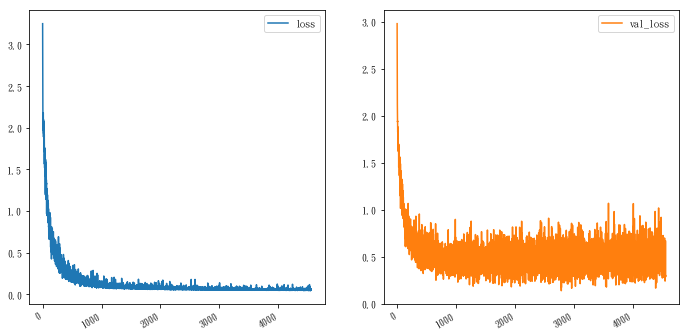

In [23]:
df[["loss","val_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000216868E7F98>,
      dtype=object)

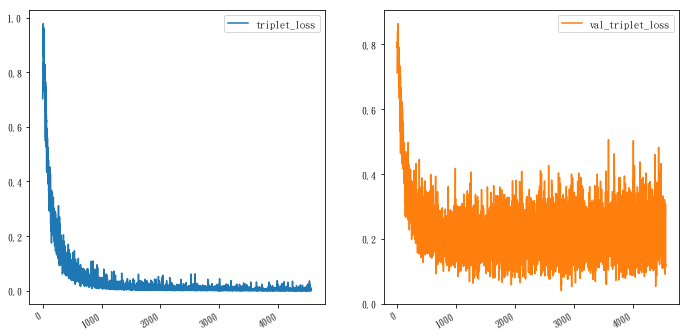

In [24]:
df[["triplet_loss","val_triplet_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021686BBE940>,
      dtype=object)

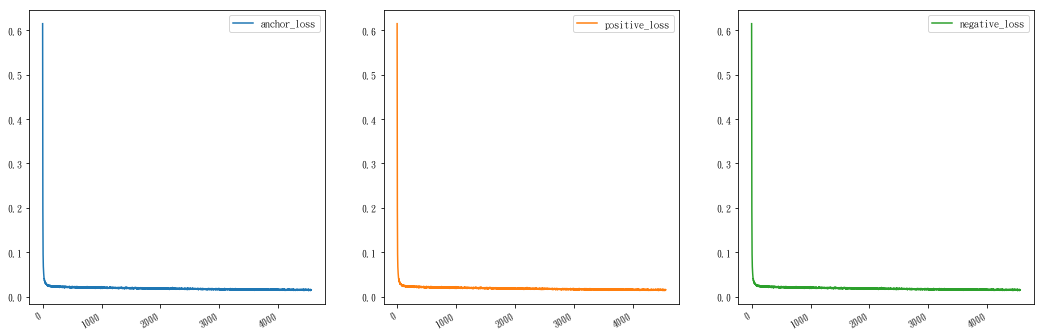

In [25]:
df[["anchor_loss","positive_loss","negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021686A00F28>,
      dtype=object)

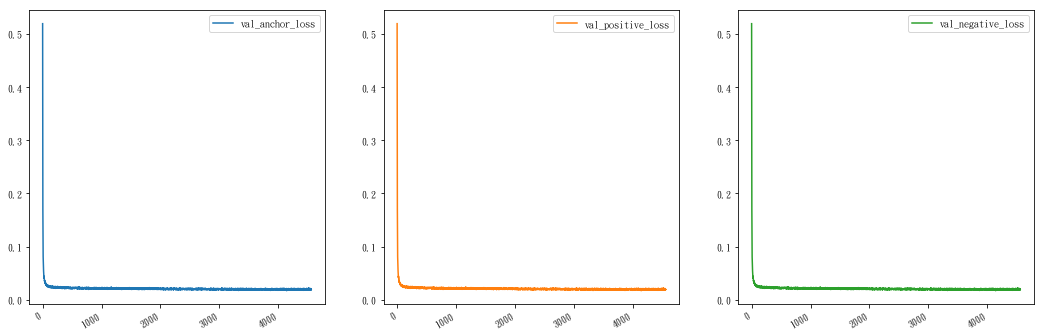

In [26]:
df[["val_anchor_loss","val_positive_loss","val_negative_loss"]].plot(subplots=True,layout=(1,3),figsize=(18,6))